
### 라이브러리 import

In [1]:
# !pip install optuna
# !pip install torchinfo

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

## 전체 공통 함수

### 1. 데이터 보간 함수

- 데이터의 시간 간격을 0.5초의 등간격으로 맞추고 그에 따른 좌표 값을 보간함
- 가장 많이 사용되는 3차 스플라인 보간 적용

In [3]:
from scipy.interpolate import interp1d
import numpy as np
import matplotlib.pyplot as plt

# 데이터 보간 - 위도, 고도, 경도 값을 0.5초 시간 간격으로 보간
def spline_interpolation(x, y):
    # x: 보간할 데이터의 x 값 (시간)
    # y: 보간할 데이터의 y 값 (위도, 고도, 경도)

    # 3차 스플라인 보간 함수 생성
    f = interp1d(x, y, kind='cubic')

    # 시간 범위 설정
    start_time = min(x)
    end_time = max(x)

    # 0.5초 간격의 시간 배열을 생성
    new_x = np.arange(start_time, end_time, 0.5)

    # 위도, 경도, 고도 보간
    new_y = f(new_x)

    return new_x, new_y

### 2. 시퀀스 나누는 함수

- 학습을 위해 데이터를 시퀀스 형태로 나눔
- look back과 forward에 따라 학습에 사용될 x값의 구간과 y값을 반환함
- 초기 look back은 10, forward는 0이다.

In [4]:
# 시퀀스 생성 함수
# look back : 10 (5초간의 위도, 고도, 경도 데이터를 x값으로 사용)
# forward : 0 (0.5초 뒤의 위도, 고도, 경도 데이터를 y값으로 사용)
def create_sequences(df, look_back=30, forward=5):
    xs = []
    ys = []
    for i in range(len(df) - look_back - forward):
        x = df.iloc[i:(i+look_back)].values
        y = df.iloc[i+look_back+forward].values
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

### 3. 시간 소수점 절사 함수

- 불필요한 시간 소수점 제거

In [5]:
import math

# 시간 소수점 절사 함수
def truncation(df):
    new_time = []

    for a in df['time']:
      new_time.append(math.floor(a * 10) / 10)

    df['time'] = new_time

    return df

### 4. 스케일링 함수

- MinMaxScaling 적용 함수


In [6]:
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaling 적용 함수
def min_max_scaling(df):

    # time 삭제 df 생성
    mid_df=df.drop(columns='time')

    min_max_scaler = MinMaxScaler()
    min_max_scaler.fit(mid_df)

    min_max_data = min_max_scaler.transform(mid_df)

    new_data = pd.DataFrame(min_max_data)

    # time 추가
    new_data.insert(0, 'time', df['time'])

    # 나머지 열의 이름 가져오기
    column_names = mid_df.columns.tolist()

    column_names.insert(0, 'time')

    print(column_names)

    # 새로운 데이터프레임에 열 이름 설정
    new_data.columns = column_names

    return min_max_scaler, new_data

### 5. train/validation/test 분리 함수

- Train, Validation, Test 데이터셋을 분리하는 함수이다.
- 각각의 비율은 6:2:2 이다.

In [7]:
from sklearn.model_selection import train_test_split

# train/validation/test 분리 함수
def split_train_val_test(df, test_size=0.2, val_size=0.25):

    #Train, Test 분류
    train_val_df, test_df = train_test_split(df, test_size=test_size, shuffle=False)

    #Train, Validation 분류
    train_df, val_df = train_test_split(train_val_df, test_size=val_size, shuffle=False)

    # # 데이터 크기 출력
    # print("Train set:", train_df.shape)
    # print("Validation set:", val_df.shape)
    # print("Test set:", test_df.shape)

    return train_df, val_df, test_df

### 6. 경로 시각화 함수

- 실제 경로와 예측 경로를 각각 그래프로 생성

In [8]:
import matplotlib.pyplot as plt

# 경로 시각화 함수
def prediction_visualization(y_test, y_pred):
    # 시각화를 위해 위도, 경도, 고도 분리
    y_test_lat = y_test[:, 0]
    y_test_lon = y_test[:, 1]
    y_test_alt = y_test[:, 2]

    y_pred_lat = y_pred[:, 0]
    y_pred_lon = y_pred[:, 1]
    y_pred_alt = y_pred[:, 2]

    # 3D 그래프 생성
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # 실제 값 플롯
    ax.scatter(y_test_lat, y_test_lon, y_test_alt, c='b', marker='o', label='Actual')

    # 예측 값 플롯
    ax.scatter(y_pred_lat, y_pred_lon, y_pred_alt, c='r', marker='^', label='Predicted')

    # 그래프 제목 및 축 레이블 설정
    ax.set_title('Actual vs Predicted')
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Longitude')
    ax.set_zlabel('Altitude')

    # 범례
    ax.legend()

    # 그래프를 화면에 출력
    plt.show()

In [9]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# splited 데이터 경로 시각화 함수
def plot_trajectory(train_data, val_data, test_data):
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    # 훈련 데이터 플롯
    ax.plot(train_data['lat'], train_data['lon'], train_data['alt'], label='Train', color='blue')

    # 검증 데이터 플롯
    ax.plot(val_data['lat'], val_data['lon'], val_data['alt'], label='Validation', color='green')

    # 테스트 데이터 플롯
    ax.plot(test_data['lat'], test_data['lon'], test_data['alt'], label='Test', color='red')

    # 그래프 레이블
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Longitude')
    ax.set_zlabel('Altitude')

    # 제목과 범례
    ax.set_title('Drone Trajectory: Train, Validation, and Test')
    ax.legend()

    plt.show()


### 7. 데이터로더 생성 함수

- 학습에 사용할 데이터 로더 생성
1. 시퀀스 생성
2. Train, Validation, Test 분리
3. DataLoader 생성

In [10]:
# 데이터 로더 생성 함수
def create_dataloaders(tri, batch_size, sequence_length):

  tri = tri[['time', 'lat', 'lon', 'alt']]

  # train, validation, test 분리
  train_data, val_data, test_data = split_train_val_test(tri)

  # 각 데이터셋에서 시퀀스 생성
  X_train, y_train = create_sequences(train_data[['lat', 'lon', 'alt']], look_back=sequence_length, forward=5)
  X_val, y_val = create_sequences(val_data[['lat', 'lon', 'alt']], look_back=sequence_length, forward=5)
  X_test, y_test = create_sequences(test_data[['lat', 'lon', 'alt']], look_back=sequence_length, forward=5)

  X_train = torch.tensor(X_train, dtype=torch.float32)
  y_train = torch.tensor(y_train, dtype=torch.float32)
  X_val = torch.tensor(X_val, dtype=torch.float32)
  y_val = torch.tensor(y_val, dtype=torch.float32)
  X_test = torch.tensor(X_test, dtype=torch.float32)
  y_test = torch.tensor(y_test, dtype=torch.float32)

  train_dataset = TensorDataset(X_train, y_train)
  validation_dataset = TensorDataset(X_val, y_val)
  test_dataset = TensorDataset(X_test, y_test)

  # 데이터 로더 생성
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  val_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

  return train_loader, val_loader, test_loader

## 전처리

### 1. 데이터셋 가져오기

In [11]:
import pandas as pd

# 데이터셋 가져오기 (필요시 저장 경로 수정)
raw = pd.read_csv("OnboardGPS.csv")

### 2. 데이터셋 전처리

- 데이터셋 보간
- 소수점 절사
- MinMaxScaling 적용


In [12]:
tri = raw[['Timpstemp', ' lat', ' lon', ' alt']]

new_x, lat = spline_interpolation(tri['Timpstemp'] / 1e6 , tri[' lat'])
new_x, lon = spline_interpolation(tri['Timpstemp'] / 1e6 , tri[' lon'])
new_x, alt = spline_interpolation(tri['Timpstemp'] / 1e6 , tri[' alt'])

tri = pd.DataFrame({"time":new_x, "lat":lat, "lon":lon, "alt":alt})

tri = truncation(tri)
scaler, tri = min_max_scaling(tri)
# tri

['time', 'lat', 'lon', 'alt']


## 모델 선언

### 1. 모델 클래스 선언
- Transformer를 사용한 모델 클래스 선언
- 구조 : Transformer + Positional Encoding + Fully Connected Layer

In [13]:
import math
import torch

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.0, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        self.pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)

        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        self.pe[:, 0::2] = torch.sin(position * div_term)  # Even indices

        self.pe = self.pe.unsqueeze(0)

    def forward(self, x):
        if self.pe.shape[2] != x.shape[2]:
            raise ValueError(f"Positional encoding dim {self.pe.shape[2]} does not match input dim {x.shape[2]}")

        x = x + self.pe[:, :x.size(1), :].to(x.device)  # Add positional encoding
        return self.dropout(x)

In [14]:
import torch.nn as nn
import torch

class TransformerModel(nn.Module):
    def __init__(self, input_dim, output_dim=3, d_model=64, nhead=4, num_encoder_layers=2, dim_feedforward=512, dropout=0.0):
        super(TransformerModel, self).__init__()

        self.embedding = nn.Linear(input_dim, d_model)
        self.positional_encoding = PositionalEncoding(d_model=d_model, dropout=dropout)

        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=d_model,
                                       nhead=nhead,
                                       dim_feedforward=dim_feedforward,
                                       dropout=dropout,
                                       batch_first=True  # batch_first 사용
            ),
            num_layers=num_encoder_layers
        )

        self.fc_out = nn.Linear(d_model, output_dim)

    def forward(self, src):
        # embedding과 positional encoding 적용
        src = self.embedding(src)
        src = self.positional_encoding(src)

        # transformer encoder 통과 (batch_first=True이므로 permute 필요 없음)
        output = self.transformer_encoder(src)

        # fully connected layer 통과
        output = self.fc_out(output)

        return output[:, -1, :]  # 마지막 시퀀스의 출력만 반환


## Optuna

In [15]:
def objective(trial, train_data, sequence_length):
    nhead = trial.suggest_int('nhead', 2, 8)

    d_model = trial.suggest_int('d_model', nhead * 8, nhead * 64, step=nhead)
    if d_model % 2 != 0:
        d_model += 1
    if d_model % nhead != 0:
        d_model += nhead - (d_model % nhead)

    num_encoder_layers = trial.suggest_int('num_encoder_layers', 1, 4)
    dim_feedforward = trial.suggest_int('dim_feedforward', 128, 512)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2)
    batch_size = trial.suggest_int('batch_size', 16, 128)

    ## 값 지정
    num_epochs = 632
    input_size = 3    # lat, lon, alt
    output_size = 3    # lat, lon, alt
    dropout = 0.0

    # 데이터 로더 생성
    train_loader, val_loader, _ = create_dataloaders(train_data, batch_size, sequence_length)

    # Transformer model 정의
    model = TransformerModel(
        input_dim=input_size,
        output_dim=output_size,
        d_model=d_model,
        nhead=nhead,
        num_encoder_layers=num_encoder_layers,
        dim_feedforward=dim_feedforward,
        dropout=dropout
    )

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    # Loss function
    criterion = nn.MSELoss()

    # Optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    total_val_loss = 0.0
    val_loss_count = 0

    # 모델 학습
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            optimizer.zero_grad()
            output = model(batch_x)
            loss = criterion(output, batch_y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_x = batch_x.to(device)
                batch_y = batch_y.to(device)
                output = model(batch_x)
                loss = criterion(output, batch_y)
                val_loss += loss.item()

        val_loss_avg = val_loss / len(val_loader)

        trial.report(val_loss_avg, epoch)

        total_val_loss += val_loss_avg
        val_loss_count += 1

        if trial.should_prune():
            print(f"Trial {trial.number} pruned at epoch {epoch}")
            raise optuna.TrialPruned()

    return total_val_loss / val_loss_count

In [16]:
sequence_length = 30
early_stopping_rounds = 10
n_trials = 70

In [17]:
import optuna

# Optuna 스터디 생성 및 최적화 실행
study = optuna.create_study(direction="minimize", pruner=optuna.pruners.MedianPruner(n_warmup_steps=10))
study.optimize(lambda trial: objective(trial, tri, sequence_length), n_trials=n_trials)

# 최적의 하이퍼파라미터 출력
print("Best hyperparameters: ", study.best_params)

[I 2024-10-22 14:22:56,912] A new study created in memory with name: no-name-512a8210-8a71-4c98-a97b-e3df09e5cf5d


/home/202004182/anaconda3/envs/env0/lib/python3.10/site-packages/torch/cuda/__init__.py:128: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11050). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at /opt/conda/conda-bld/pytorch_1720538459595/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


[I 2024-10-22 19:21:48,168] Trial 0 finished with value: 0.10691987408482619 and parameters: {'nhead': 8, 'd_model': 344, 'num_encoder_layers': 3, 'dim_feedforward': 207, 'learning_rate': 0.006680975992977662, 'batch_size': 102}. Best is trial 0 with value: 0.10691987408482619.


/home/202004182/anaconda3/envs/env0/lib/python3.10/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


[I 2024-10-22 21:22:08,772] Trial 1 finished with value: 0.0015419400963254536 and parameters: {'nhead': 5, 'd_model': 130, 'num_encoder_layers': 1, 'dim_feedforward': 214, 'learning_rate': 0.0005755229287527855, 'batch_size': 73}. Best is trial 1 with value: 0.0015419400963254536.


[I 2024-10-22 23:26:12,572] Trial 2 finished with value: 0.00870968381069845 and parameters: {'nhead': 2, 'd_model': 62, 'num_encoder_layers': 2, 'dim_feedforward': 427, 'learning_rate': 0.006781880233986938, 'batch_size': 120}. Best is trial 1 with value: 0.0015419400963254536.


[I 2024-10-23 00:26:25,678] Trial 3 finished with value: 0.09736333474753141 and parameters: {'nhead': 4, 'd_model': 96, 'num_encoder_layers': 4, 'dim_feedforward': 185, 'learning_rate': 0.006538716636940369, 'batch_size': 88}. Best is trial 1 with value: 0.0015419400963254536.


/home/202004182/anaconda3/envs/env0/lib/python3.10/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


[I 2024-10-23 01:11:33,656] Trial 4 finished with value: 0.10970867842209005 and parameters: {'nhead': 3, 'd_model': 132, 'num_encoder_layers': 3, 'dim_feedforward': 316, 'learning_rate': 0.005319512396880286, 'batch_size': 20}. Best is trial 1 with value: 0.0015419400963254536.


/home/202004182/anaconda3/envs/env0/lib/python3.10/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


[I 2024-10-23 01:12:23,123] Trial 5 pruned. 


Trial 5 pruned at epoch 24


/home/202004182/anaconda3/envs/env0/lib/python3.10/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


[I 2024-10-23 01:36:30,574] Trial 6 finished with value: 0.004373059382172109 and parameters: {'nhead': 3, 'd_model': 174, 'num_encoder_layers': 4, 'dim_feedforward': 141, 'learning_rate': 0.0006480672562629964, 'batch_size': 112}. Best is trial 1 with value: 0.0015419400963254536.


[I 2024-10-23 01:47:09,922] Trial 7 finished with value: 0.009150270217226805 and parameters: {'nhead': 2, 'd_model': 44, 'num_encoder_layers': 2, 'dim_feedforward': 502, 'learning_rate': 0.005086401653958314, 'batch_size': 64}. Best is trial 1 with value: 0.0015419400963254536.


/home/202004182/anaconda3/envs/env0/lib/python3.10/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


[I 2024-10-23 01:48:30,599] Trial 8 pruned. 


Trial 8 pruned at epoch 10


[I 2024-10-23 01:49:13,608] Trial 9 pruned. 


Trial 9 pruned at epoch 10


/home/202004182/anaconda3/envs/env0/lib/python3.10/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


[I 2024-10-23 02:00:18,471] Trial 10 finished with value: 0.0015457098546452764 and parameters: {'nhead': 5, 'd_model': 210, 'num_encoder_layers': 1, 'dim_feedforward': 262, 'learning_rate': 0.0001872663479238424, 'batch_size': 56}. Best is trial 1 with value: 0.0015419400963254536.


/home/202004182/anaconda3/envs/env0/lib/python3.10/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


[I 2024-10-23 02:11:21,568] Trial 11 finished with value: 0.001478003993834564 and parameters: {'nhead': 5, 'd_model': 205, 'num_encoder_layers': 1, 'dim_feedforward': 276, 'learning_rate': 0.0001477558602538382, 'batch_size': 55}. Best is trial 11 with value: 0.001478003993834564.


/home/202004182/anaconda3/envs/env0/lib/python3.10/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


[I 2024-10-23 02:24:14,105] Trial 12 finished with value: 0.0012592932053735388 and parameters: {'nhead': 5, 'd_model': 125, 'num_encoder_layers': 1, 'dim_feedforward': 264, 'learning_rate': 0.0025440882065515488, 'batch_size': 37}. Best is trial 12 with value: 0.0012592932053735388.


[I 2024-10-23 02:50:48,197] Trial 13 finished with value: 0.001948168994378536 and parameters: {'nhead': 6, 'd_model': 270, 'num_encoder_layers': 1, 'dim_feedforward': 294, 'learning_rate': 0.0027291015822518867, 'batch_size': 36}. Best is trial 12 with value: 0.0012592932053735388.


[I 2024-10-23 02:59:50,306] Trial 14 finished with value: 0.002704179071968271 and parameters: {'nhead': 4, 'd_model': 112, 'num_encoder_layers': 1, 'dim_feedforward': 370, 'learning_rate': 0.002759332750479026, 'batch_size': 41}. Best is trial 12 with value: 0.0012592932053735388.


[I 2024-10-23 03:00:36,510] Trial 15 pruned. 


Trial 15 pruned at epoch 10


[I 2024-10-23 03:17:06,048] Trial 16 finished with value: 0.0032911997854473928 and parameters: {'nhead': 4, 'd_model': 168, 'num_encoder_layers': 1, 'dim_feedforward': 370, 'learning_rate': 0.001973673437075629, 'batch_size': 45}. Best is trial 12 with value: 0.0012592932053735388.


/home/202004182/anaconda3/envs/env0/lib/python3.10/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


[I 2024-10-23 03:40:19,903] Trial 17 finished with value: 0.0025447346394096987 and parameters: {'nhead': 5, 'd_model': 215, 'num_encoder_layers': 1, 'dim_feedforward': 265, 'learning_rate': 0.003495976409892108, 'batch_size': 31}. Best is trial 12 with value: 0.0012592932053735388.


/home/202004182/anaconda3/envs/env0/lib/python3.10/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


[I 2024-10-23 03:40:48,995] Trial 18 pruned. 


Trial 18 pruned at epoch 10


/home/202004182/anaconda3/envs/env0/lib/python3.10/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


[I 2024-10-23 03:49:32,104] Trial 19 finished with value: 0.0008050780436801322 and parameters: {'nhead': 3, 'd_model': 81, 'num_encoder_layers': 1, 'dim_feedforward': 233, 'learning_rate': 0.0012965635932596514, 'batch_size': 72}. Best is trial 19 with value: 0.0008050780436801322.


/home/202004182/anaconda3/envs/env0/lib/python3.10/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


[I 2024-10-23 04:03:42,352] Trial 20 finished with value: 0.0035505343555745183 and parameters: {'nhead': 3, 'd_model': 78, 'num_encoder_layers': 2, 'dim_feedforward': 226, 'learning_rate': 0.0014855640534991296, 'batch_size': 69}. Best is trial 19 with value: 0.0008050780436801322.


[I 2024-10-23 04:03:51,851] Trial 21 pruned. 


Trial 21 pruned at epoch 11


[I 2024-10-23 04:15:08,258] Trial 22 finished with value: 0.002853621857871568 and parameters: {'nhead': 6, 'd_model': 144, 'num_encoder_layers': 1, 'dim_feedforward': 177, 'learning_rate': 0.0037518471768043593, 'batch_size': 54}. Best is trial 19 with value: 0.0008050780436801322.


/home/202004182/anaconda3/envs/env0/lib/python3.10/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


[I 2024-10-23 04:26:12,065] Trial 23 finished with value: 0.003421940602685423 and parameters: {'nhead': 5, 'd_model': 40, 'num_encoder_layers': 1, 'dim_feedforward': 242, 'learning_rate': 0.0014687042580546217, 'batch_size': 25}. Best is trial 19 with value: 0.0008050780436801322.


/home/202004182/anaconda3/envs/env0/lib/python3.10/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


[I 2024-10-23 04:26:22,951] Trial 24 pruned. 


Trial 24 pruned at epoch 10


[I 2024-10-23 04:26:37,647] Trial 25 pruned. 


Trial 25 pruned at epoch 10


[I 2024-10-23 04:26:42,774] Trial 26 pruned. 


Trial 26 pruned at epoch 10


/home/202004182/anaconda3/envs/env0/lib/python3.10/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


[I 2024-10-23 04:53:14,467] Trial 27 finished with value: 0.002069362465374938 and parameters: {'nhead': 5, 'd_model': 190, 'num_encoder_layers': 2, 'dim_feedforward': 276, 'learning_rate': 0.0010075938945627548, 'batch_size': 33}. Best is trial 19 with value: 0.0008050780436801322.


[I 2024-10-23 04:53:39,719] Trial 28 pruned. 


Trial 28 pruned at epoch 10


[I 2024-10-23 04:54:12,898] Trial 29 pruned. 


Trial 29 pruned at epoch 10


[I 2024-10-23 05:04:13,554] Trial 30 finished with value: 0.0006478062808373018 and parameters: {'nhead': 6, 'd_model': 120, 'num_encoder_layers': 1, 'dim_feedforward': 198, 'learning_rate': 0.00100793565377167, 'batch_size': 67}. Best is trial 30 with value: 0.0006478062808373018.


[I 2024-10-23 05:04:28,945] Trial 31 pruned. 


Trial 31 pruned at epoch 13


/home/202004182/anaconda3/envs/env0/lib/python3.10/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


[I 2024-10-23 05:04:49,045] Trial 32 pruned. 


Trial 32 pruned at epoch 11


/home/202004182/anaconda3/envs/env0/lib/python3.10/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


[I 2024-10-23 05:23:46,453] Trial 33 finished with value: 0.002986284026385788 and parameters: {'nhead': 7, 'd_model': 217, 'num_encoder_layers': 1, 'dim_feedforward': 160, 'learning_rate': 0.0018733854118569647, 'batch_size': 39}. Best is trial 30 with value: 0.0006478062808373018.


[I 2024-10-23 05:34:31,083] Trial 34 finished with value: 0.0032979442649697164 and parameters: {'nhead': 6, 'd_model': 144, 'num_encoder_layers': 1, 'dim_feedforward': 217, 'learning_rate': 0.003282871416377838, 'batch_size': 68}. Best is trial 30 with value: 0.0006478062808373018.


/home/202004182/anaconda3/envs/env0/lib/python3.10/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


[I 2024-10-23 05:47:10,388] Trial 35 finished with value: 0.002987146168763273 and parameters: {'nhead': 5, 'd_model': 115, 'num_encoder_layers': 2, 'dim_feedforward': 239, 'learning_rate': 0.0007644570088744344, 'batch_size': 98}. Best is trial 30 with value: 0.0006478062808373018.


[I 2024-10-23 05:47:18,827] Trial 36 pruned. 


Trial 36 pruned at epoch 11


[I 2024-10-23 06:15:16,413] Trial 37 finished with value: 0.005495919213683533 and parameters: {'nhead': 2, 'd_model': 66, 'num_encoder_layers': 2, 'dim_feedforward': 309, 'learning_rate': 0.0012935310262259172, 'batch_size': 27}. Best is trial 30 with value: 0.0006478062808373018.


/home/202004182/anaconda3/envs/env0/lib/python3.10/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


[I 2024-10-23 06:23:30,703] Trial 38 finished with value: 0.0019084588693604248 and parameters: {'nhead': 3, 'd_model': 120, 'num_encoder_layers': 1, 'dim_feedforward': 157, 'learning_rate': 0.004568123192676352, 'batch_size': 60}. Best is trial 30 with value: 0.0006478062808373018.


/home/202004182/anaconda3/envs/env0/lib/python3.10/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


[I 2024-10-23 06:23:58,306] Trial 39 pruned. 


Trial 39 pruned at epoch 10


/home/202004182/anaconda3/envs/env0/lib/python3.10/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


[I 2024-10-23 06:24:13,660] Trial 40 pruned. 


Trial 40 pruned at epoch 10


[I 2024-10-23 06:33:16,378] Trial 41 finished with value: 0.0013923617133147033 and parameters: {'nhead': 6, 'd_model': 102, 'num_encoder_layers': 1, 'dim_feedforward': 206, 'learning_rate': 0.0005593765994277426, 'batch_size': 80}. Best is trial 30 with value: 0.0006478062808373018.


[I 2024-10-23 06:41:20,789] Trial 42 finished with value: 0.0012051606238620467 and parameters: {'nhead': 6, 'd_model': 96, 'num_encoder_layers': 1, 'dim_feedforward': 211, 'learning_rate': 0.0005650269042242173, 'batch_size': 83}. Best is trial 30 with value: 0.0006478062808373018.


[I 2024-10-23 06:49:19,515] Trial 43 finished with value: 0.001407516094055553 and parameters: {'nhead': 6, 'd_model': 102, 'num_encoder_layers': 1, 'dim_feedforward': 201, 'learning_rate': 0.0017087985381184327, 'batch_size': 94}. Best is trial 30 with value: 0.0006478062808373018.


/home/202004182/anaconda3/envs/env0/lib/python3.10/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


[I 2024-10-23 06:50:21,641] Trial 44 pruned. 


Trial 44 pruned at epoch 28


[I 2024-10-23 06:50:29,753] Trial 45 pruned. 


Trial 45 pruned at epoch 10


/home/202004182/anaconda3/envs/env0/lib/python3.10/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


[I 2024-10-23 06:50:40,716] Trial 46 pruned. 


Trial 46 pruned at epoch 13


[I 2024-10-23 06:59:58,891] Trial 47 finished with value: 0.005629591304810292 and parameters: {'nhead': 6, 'd_model': 102, 'num_encoder_layers': 1, 'dim_feedforward': 512, 'learning_rate': 0.003070644131881433, 'batch_size': 87}. Best is trial 30 with value: 0.0006478062808373018.


[I 2024-10-23 07:00:07,276] Trial 48 pruned. 


Trial 48 pruned at epoch 10


/home/202004182/anaconda3/envs/env0/lib/python3.10/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


[I 2024-10-23 07:00:24,773] Trial 49 pruned. 


Trial 49 pruned at epoch 10


[I 2024-10-23 07:00:31,749] Trial 50 pruned. 


Trial 50 pruned at epoch 10


[I 2024-10-23 07:00:41,876] Trial 51 pruned. 


Trial 51 pruned at epoch 13


/home/202004182/anaconda3/envs/env0/lib/python3.10/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


[I 2024-10-23 07:00:48,381] Trial 52 pruned. 


Trial 52 pruned at epoch 10


[I 2024-10-23 07:08:43,661] Trial 53 finished with value: 0.0007814148461483029 and parameters: {'nhead': 6, 'd_model': 114, 'num_encoder_layers': 1, 'dim_feedforward': 176, 'learning_rate': 0.0017366720648858006, 'batch_size': 87}. Best is trial 30 with value: 0.0006478062808373018.


/home/202004182/anaconda3/envs/env0/lib/python3.10/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


[I 2024-10-23 07:08:52,609] Trial 54 pruned. 


Trial 54 pruned at epoch 10


[I 2024-10-23 07:16:34,222] Trial 55 finished with value: 0.0012790291611207221 and parameters: {'nhead': 6, 'd_model': 90, 'num_encoder_layers': 1, 'dim_feedforward': 174, 'learning_rate': 0.0028455729771709715, 'batch_size': 79}. Best is trial 30 with value: 0.0006478062808373018.


/home/202004182/anaconda3/envs/env0/lib/python3.10/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


[I 2024-10-23 07:16:41,808] Trial 56 pruned. 


Trial 56 pruned at epoch 10


/home/202004182/anaconda3/envs/env0/lib/python3.10/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


[I 2024-10-23 07:16:53,308] Trial 57 pruned. 


Trial 57 pruned at epoch 13


[I 2024-10-23 07:27:18,832] Trial 58 finished with value: 0.0007133054715091007 and parameters: {'nhead': 4, 'd_model': 92, 'num_encoder_layers': 1, 'dim_feedforward': 249, 'learning_rate': 0.0029253371817930616, 'batch_size': 67}. Best is trial 30 with value: 0.0006478062808373018.


[I 2024-10-23 07:39:08,113] Trial 59 finished with value: 0.0006097317363219262 and parameters: {'nhead': 4, 'd_model': 136, 'num_encoder_layers': 1, 'dim_feedforward': 274, 'learning_rate': 0.003953864235868401, 'batch_size': 68}. Best is trial 59 with value: 0.0006097317363219262.


/home/202004182/anaconda3/envs/env0/lib/python3.10/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


[I 2024-10-23 07:51:42,226] Trial 60 finished with value: 0.0063961302037315836 and parameters: {'nhead': 3, 'd_model': 138, 'num_encoder_layers': 1, 'dim_feedforward': 250, 'learning_rate': 0.0041511490862357284, 'batch_size': 65}. Best is trial 59 with value: 0.0006097317363219262.


[I 2024-10-23 07:59:52,640] Trial 61 finished with value: 0.0012128262513783896 and parameters: {'nhead': 4, 'd_model': 120, 'num_encoder_layers': 1, 'dim_feedforward': 270, 'learning_rate': 0.003498133151477143, 'batch_size': 59}. Best is trial 59 with value: 0.0006097317363219262.


[I 2024-10-23 08:00:02,624] Trial 62 pruned. 


Trial 62 pruned at epoch 12


[I 2024-10-23 08:12:08,121] Trial 63 finished with value: 0.001248080557754069 and parameters: {'nhead': 4, 'd_model': 108, 'num_encoder_layers': 1, 'dim_feedforward': 323, 'learning_rate': 0.0035884312028349515, 'batch_size': 58}. Best is trial 59 with value: 0.0006097317363219262.


[I 2024-10-23 08:23:46,993] Trial 64 finished with value: 0.001209064755917812 and parameters: {'nhead': 4, 'd_model': 124, 'num_encoder_layers': 1, 'dim_feedforward': 298, 'learning_rate': 0.003333730269372428, 'batch_size': 65}. Best is trial 59 with value: 0.0006097317363219262.


[I 2024-10-23 08:23:55,999] Trial 65 pruned. 


Trial 65 pruned at epoch 10


/home/202004182/anaconda3/envs/env0/lib/python3.10/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


[I 2024-10-23 08:24:24,407] Trial 66 pruned. 


Trial 66 pruned at epoch 10


[I 2024-10-23 09:11:05,744] Trial 67 finished with value: 0.002019529272237791 and parameters: {'nhead': 4, 'd_model': 124, 'num_encoder_layers': 1, 'dim_feedforward': 343, 'learning_rate': 0.002239452897053593, 'batch_size': 68}. Best is trial 59 with value: 0.0006097317363219262.


/home/202004182/anaconda3/envs/env0/lib/python3.10/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


[I 2024-10-23 09:12:25,412] Trial 68 pruned. 


Trial 68 pruned at epoch 13


[I 2024-10-23 09:14:22,121] Trial 69 pruned. 


Trial 69 pruned at epoch 10
Best hyperparameters:  {'nhead': 4, 'd_model': 136, 'num_encoder_layers': 1, 'dim_feedforward': 274, 'learning_rate': 0.003953864235868401, 'batch_size': 68}


In [18]:
import json

### 하이퍼 파라미터 저장

# 최적의 하이퍼파라미터를 JSON 파일로 저장
with open("best_hyperparameters.json", "w") as f:
    json.dump(study.best_params, f, indent=4)

print("Best hyperparameters have been saved to 'best_hyperparameters.json'")

Best hyperparameters have been saved to 'best_hyperparameters.json'


## 학습

### 1. 하이퍼파라미터 불러오기

In [19]:
import json

# 저장된 하이퍼파라미터 불러오기
with open("best_hyperparameters.json", "r") as f:
    best_params = json.load(f)

print("Loaded best hyperparameters:", best_params)

Loaded best hyperparameters: {'nhead': 4, 'd_model': 136, 'num_encoder_layers': 1, 'dim_feedforward': 274, 'learning_rate': 0.003953864235868401, 'batch_size': 68}


### 2. 최적의 파라미터로 모델 학습

In [20]:
sequence_length = 30
num_epochs = 632

In [21]:
# 최적의 모델 학습
# best_params = study.best_params

train_loader, val_loader, test_loader = create_dataloaders(tri, best_params['batch_size'], sequence_length)

best_model = TransformerModel(
    input_dim=3,
    d_model=best_params['d_model'],
    nhead=best_params['nhead'],
    num_encoder_layers=best_params['num_encoder_layers'],
    dim_feedforward=best_params['dim_feedforward']
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
best_model = best_model.to(device)

optimizer = torch.optim.Adam(best_model.parameters(), lr=best_params['learning_rate'])
criterion = torch.nn.MSELoss()

In [22]:
import time
import torch

# 학습 및 검증 손실을 기록할 리스트
train_losses = []
val_losses = []

best_model.train()
total_train_time = 0  # 총 학습 시간 기록 변수

for epoch in range(num_epochs):  # 최종 모델 학습
    best_model.train()
    train_loss = 0.0
    epoch_start_time = time.time()  # 에포크 시작 시간 기록
    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to(device)  # 입력 데이터 차원 조정
        batch_y = batch_y.to(device)
        optimizer.zero_grad()
        output = best_model(batch_x)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    epoch_end_time = time.time()  # 에포크 종료 시간 기록
    epoch_duration = epoch_end_time - epoch_start_time  # 한 에포크의 학습 시간
    total_train_time += epoch_duration  # 총 학습 시간에 추가

    # Validation set에서 성능 측정
    best_model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x = batch_x.to(device)  # 입력 데이터 차원 조정
            batch_y = batch_y.to(device)
            output = best_model(batch_x)
            loss = criterion(output, batch_y)
            val_loss += loss.item()

    # 평균 손실 계산 및 저장
    train_losses.append(train_loss / len(train_loader))
    val_losses.append(val_loss / len(val_loader))

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    # 모델 저장
    if (epoch + 1) % 100 == 0 or epoch + 1 == 632:

      # Model Save
      model_save_path = f"./output_model/best_model_epoch_{epoch+1}.pth"
      torch.save({
        'model_state_dict': best_model.state_dict(),
        'train_losses': train_losses,
        'val_losses': val_losses
      }, model_save_path)
      print(f"Model saved: {model_save_path}")

    print(f"Epoch {epoch+1}/{num_epochs} completed in {epoch_duration:.2f} seconds.")

print(f"Total training time: {total_train_time:.2f} seconds.")


Epoch [1/632], Train Loss: 8.4690, Val Loss: 0.3023
Epoch 1/632 completed in 6.69 seconds.


Epoch [2/632], Train Loss: 0.2532, Val Loss: 0.0272
Epoch 2/632 completed in 6.80 seconds.


Epoch [3/632], Train Loss: 0.0419, Val Loss: 0.0331
Epoch 3/632 completed in 4.38 seconds.


Epoch [4/632], Train Loss: 0.0354, Val Loss: 0.0100
Epoch 4/632 completed in 4.35 seconds.


Epoch [5/632], Train Loss: 0.0208, Val Loss: 0.0143
Epoch 5/632 completed in 2.14 seconds.


Epoch [6/632], Train Loss: 0.0330, Val Loss: 0.0590
Epoch 6/632 completed in 3.02 seconds.


Epoch [7/632], Train Loss: 0.0236, Val Loss: 0.0086
Epoch 7/632 completed in 2.39 seconds.


Epoch [8/632], Train Loss: 0.0157, Val Loss: 0.0248
Epoch 8/632 completed in 3.16 seconds.


Epoch [9/632], Train Loss: 0.0271, Val Loss: 0.0088
Epoch 9/632 completed in 5.82 seconds.


Epoch [10/632], Train Loss: 0.0202, Val Loss: 0.0095
Epoch 10/632 completed in 3.84 seconds.


Epoch [11/632], Train Loss: 0.0244, Val Loss: 0.0092
Epoch 11/632 completed in 4.70 seconds.


Epoch [12/632], Train Loss: 0.0226, Val Loss: 0.0189
Epoch 12/632 completed in 3.25 seconds.


Epoch [13/632], Train Loss: 0.0218, Val Loss: 0.0064
Epoch 13/632 completed in 6.19 seconds.


Epoch [14/632], Train Loss: 0.0159, Val Loss: 0.0061
Epoch 14/632 completed in 4.41 seconds.


Epoch [15/632], Train Loss: 0.0212, Val Loss: 0.0121
Epoch 15/632 completed in 3.93 seconds.


Epoch [16/632], Train Loss: 0.0208, Val Loss: 0.0069
Epoch 16/632 completed in 3.90 seconds.


Epoch [17/632], Train Loss: 0.0171, Val Loss: 0.0091
Epoch 17/632 completed in 4.45 seconds.


Epoch [18/632], Train Loss: 0.0196, Val Loss: 0.0073
Epoch 18/632 completed in 5.51 seconds.


Epoch [19/632], Train Loss: 0.0202, Val Loss: 0.0096
Epoch 19/632 completed in 4.07 seconds.


Epoch [20/632], Train Loss: 0.0156, Val Loss: 0.0069
Epoch 20/632 completed in 3.71 seconds.


Epoch [21/632], Train Loss: 0.0187, Val Loss: 0.0101
Epoch 21/632 completed in 3.64 seconds.


Epoch [22/632], Train Loss: 0.0231, Val Loss: 0.0094
Epoch 22/632 completed in 3.49 seconds.


Epoch [23/632], Train Loss: 0.0294, Val Loss: 0.0152
Epoch 23/632 completed in 5.66 seconds.


Epoch [24/632], Train Loss: 0.0191, Val Loss: 0.0113
Epoch 24/632 completed in 5.62 seconds.


Epoch [25/632], Train Loss: 0.0157, Val Loss: 0.0110
Epoch 25/632 completed in 5.41 seconds.


Epoch [26/632], Train Loss: 0.0262, Val Loss: 0.0046
Epoch 26/632 completed in 19.21 seconds.


Epoch [27/632], Train Loss: 0.0201, Val Loss: 0.0052
Epoch 27/632 completed in 7.76 seconds.


Epoch [28/632], Train Loss: 0.0184, Val Loss: 0.0103
Epoch 28/632 completed in 6.03 seconds.


Epoch [29/632], Train Loss: 0.0173, Val Loss: 0.0079
Epoch 29/632 completed in 5.77 seconds.


Epoch [30/632], Train Loss: 0.0186, Val Loss: 0.0061
Epoch 30/632 completed in 3.31 seconds.


Epoch [31/632], Train Loss: 0.0219, Val Loss: 0.0047
Epoch 31/632 completed in 5.07 seconds.


Epoch [32/632], Train Loss: 0.0135, Val Loss: 0.0061
Epoch 32/632 completed in 4.17 seconds.


Epoch [33/632], Train Loss: 0.0145, Val Loss: 0.0069
Epoch 33/632 completed in 5.54 seconds.


Epoch [34/632], Train Loss: 0.0214, Val Loss: 0.0053
Epoch 34/632 completed in 4.92 seconds.


Epoch [35/632], Train Loss: 0.0288, Val Loss: 0.0115
Epoch 35/632 completed in 4.39 seconds.


Epoch [36/632], Train Loss: 0.0156, Val Loss: 0.0057
Epoch 36/632 completed in 3.39 seconds.


Epoch [37/632], Train Loss: 0.0249, Val Loss: 0.0096
Epoch 37/632 completed in 4.42 seconds.


Epoch [38/632], Train Loss: 0.0273, Val Loss: 0.0073
Epoch 38/632 completed in 4.65 seconds.


Epoch [39/632], Train Loss: 0.0199, Val Loss: 0.0061
Epoch 39/632 completed in 4.44 seconds.


Epoch [40/632], Train Loss: 0.0143, Val Loss: 0.0058
Epoch 40/632 completed in 3.01 seconds.


Epoch [41/632], Train Loss: 0.0138, Val Loss: 0.0048
Epoch 41/632 completed in 4.87 seconds.


Epoch [42/632], Train Loss: 0.0129, Val Loss: 0.0055
Epoch 42/632 completed in 4.63 seconds.


Epoch [43/632], Train Loss: 0.0239, Val Loss: 0.0112
Epoch 43/632 completed in 4.59 seconds.


Epoch [44/632], Train Loss: 0.0136, Val Loss: 0.0077
Epoch 44/632 completed in 3.94 seconds.


Epoch [45/632], Train Loss: 0.0156, Val Loss: 0.0055
Epoch 45/632 completed in 5.18 seconds.


Epoch [46/632], Train Loss: 0.0241, Val Loss: 0.0082
Epoch 46/632 completed in 3.27 seconds.


Epoch [47/632], Train Loss: 0.0169, Val Loss: 0.0056
Epoch 47/632 completed in 5.65 seconds.


Epoch [48/632], Train Loss: 0.0110, Val Loss: 0.0053
Epoch 48/632 completed in 5.48 seconds.


Epoch [49/632], Train Loss: 0.0186, Val Loss: 0.0084
Epoch 49/632 completed in 6.55 seconds.


Epoch [50/632], Train Loss: 0.0166, Val Loss: 0.0077
Epoch 50/632 completed in 3.36 seconds.


Epoch [51/632], Train Loss: 0.0201, Val Loss: 0.0054
Epoch 51/632 completed in 5.00 seconds.


Epoch [52/632], Train Loss: 0.0176, Val Loss: 0.0051
Epoch 52/632 completed in 12.77 seconds.


Epoch [53/632], Train Loss: 0.0147, Val Loss: 0.0076
Epoch 53/632 completed in 5.71 seconds.


Epoch [54/632], Train Loss: 0.0141, Val Loss: 0.0066
Epoch 54/632 completed in 3.69 seconds.


Epoch [55/632], Train Loss: 0.0239, Val Loss: 0.0056
Epoch 55/632 completed in 4.62 seconds.


Epoch [56/632], Train Loss: 0.0140, Val Loss: 0.0047
Epoch 56/632 completed in 6.76 seconds.


Epoch [57/632], Train Loss: 0.0185, Val Loss: 0.0103
Epoch 57/632 completed in 5.29 seconds.


Epoch [58/632], Train Loss: 0.0208, Val Loss: 0.0070
Epoch 58/632 completed in 5.91 seconds.


Epoch [59/632], Train Loss: 0.0138, Val Loss: 0.0056
Epoch 59/632 completed in 3.88 seconds.


Epoch [60/632], Train Loss: 0.0164, Val Loss: 0.0050
Epoch 60/632 completed in 5.41 seconds.


Epoch [61/632], Train Loss: 0.0158, Val Loss: 0.0092
Epoch 61/632 completed in 3.99 seconds.


Epoch [62/632], Train Loss: 0.0350, Val Loss: 0.0062
Epoch 62/632 completed in 5.05 seconds.


Epoch [63/632], Train Loss: 0.0464, Val Loss: 0.0068
Epoch 63/632 completed in 6.08 seconds.


Epoch [64/632], Train Loss: 0.0150, Val Loss: 0.0049
Epoch 64/632 completed in 7.04 seconds.


Epoch [65/632], Train Loss: 0.0216, Val Loss: 0.0169
Epoch 65/632 completed in 3.94 seconds.


Epoch [66/632], Train Loss: 0.0166, Val Loss: 0.0132
Epoch 66/632 completed in 5.89 seconds.


Epoch [67/632], Train Loss: 0.0128, Val Loss: 0.0064
Epoch 67/632 completed in 4.82 seconds.


Epoch [68/632], Train Loss: 0.0131, Val Loss: 0.0083
Epoch 68/632 completed in 3.91 seconds.


Epoch [69/632], Train Loss: 0.0146, Val Loss: 0.0052
Epoch 69/632 completed in 3.44 seconds.


Epoch [70/632], Train Loss: 0.0176, Val Loss: 0.0062
Epoch 70/632 completed in 5.27 seconds.


Epoch [71/632], Train Loss: 0.0139, Val Loss: 0.0197
Epoch 71/632 completed in 4.85 seconds.


Epoch [72/632], Train Loss: 0.0129, Val Loss: 0.0051
Epoch 72/632 completed in 4.80 seconds.


Epoch [73/632], Train Loss: 0.0171, Val Loss: 0.0063
Epoch 73/632 completed in 4.92 seconds.


Epoch [74/632], Train Loss: 0.0170, Val Loss: 0.0122
Epoch 74/632 completed in 4.75 seconds.


Epoch [75/632], Train Loss: 0.0148, Val Loss: 0.0110
Epoch 75/632 completed in 5.33 seconds.


Epoch [76/632], Train Loss: 0.0204, Val Loss: 0.0166
Epoch 76/632 completed in 5.87 seconds.


Epoch [77/632], Train Loss: 0.0116, Val Loss: 0.0060
Epoch 77/632 completed in 3.26 seconds.


Epoch [78/632], Train Loss: 0.0135, Val Loss: 0.0094
Epoch 78/632 completed in 5.77 seconds.


Epoch [79/632], Train Loss: 0.0115, Val Loss: 0.0072
Epoch 79/632 completed in 4.02 seconds.


Epoch [80/632], Train Loss: 0.0182, Val Loss: 0.0095
Epoch 80/632 completed in 5.72 seconds.


Epoch [81/632], Train Loss: 0.0145, Val Loss: 0.0169
Epoch 81/632 completed in 4.97 seconds.


Epoch [82/632], Train Loss: 0.0131, Val Loss: 0.0048
Epoch 82/632 completed in 4.06 seconds.


Epoch [83/632], Train Loss: 0.0120, Val Loss: 0.0187
Epoch 83/632 completed in 4.69 seconds.


Epoch [84/632], Train Loss: 0.0163, Val Loss: 0.0082
Epoch 84/632 completed in 4.90 seconds.


Epoch [85/632], Train Loss: 0.0115, Val Loss: 0.0079
Epoch 85/632 completed in 4.94 seconds.


Epoch [86/632], Train Loss: 0.0134, Val Loss: 0.0103
Epoch 86/632 completed in 3.61 seconds.


Epoch [87/632], Train Loss: 0.0136, Val Loss: 0.0082
Epoch 87/632 completed in 4.31 seconds.


Epoch [88/632], Train Loss: 0.0142, Val Loss: 0.0196
Epoch 88/632 completed in 3.57 seconds.


Epoch [89/632], Train Loss: 0.0240, Val Loss: 0.0137
Epoch 89/632 completed in 4.06 seconds.


Epoch [90/632], Train Loss: 0.0139, Val Loss: 0.0111
Epoch 90/632 completed in 5.87 seconds.


Epoch [91/632], Train Loss: 0.0111, Val Loss: 0.0108
Epoch 91/632 completed in 5.02 seconds.


Epoch [92/632], Train Loss: 0.0108, Val Loss: 0.0100
Epoch 92/632 completed in 3.10 seconds.


Epoch [93/632], Train Loss: 0.0155, Val Loss: 0.0188
Epoch 93/632 completed in 3.94 seconds.


Epoch [94/632], Train Loss: 0.0110, Val Loss: 0.0088
Epoch 94/632 completed in 3.82 seconds.


Epoch [95/632], Train Loss: 0.0137, Val Loss: 0.0063
Epoch 95/632 completed in 3.97 seconds.


Epoch [96/632], Train Loss: 0.0169, Val Loss: 0.0159
Epoch 96/632 completed in 3.05 seconds.


Epoch [97/632], Train Loss: 0.0207, Val Loss: 0.0062
Epoch 97/632 completed in 3.72 seconds.


Epoch [98/632], Train Loss: 0.0123, Val Loss: 0.0086
Epoch 98/632 completed in 5.89 seconds.


Epoch [99/632], Train Loss: 0.0151, Val Loss: 0.0155
Epoch 99/632 completed in 5.17 seconds.


Epoch [100/632], Train Loss: 0.0152, Val Loss: 0.0081
Model saved: ./output_model/best_model_epoch_100.pth
Epoch 100/632 completed in 6.00 seconds.


Epoch [101/632], Train Loss: 0.0138, Val Loss: 0.0143
Epoch 101/632 completed in 4.45 seconds.


Epoch [102/632], Train Loss: 0.0114, Val Loss: 0.0138
Epoch 102/632 completed in 4.22 seconds.


Epoch [103/632], Train Loss: 0.0163, Val Loss: 0.0134
Epoch 103/632 completed in 4.54 seconds.


Epoch [104/632], Train Loss: 0.0111, Val Loss: 0.0103
Epoch 104/632 completed in 3.16 seconds.


Epoch [105/632], Train Loss: 0.0122, Val Loss: 0.0180
Epoch 105/632 completed in 5.66 seconds.


Epoch [106/632], Train Loss: 0.0130, Val Loss: 0.0070
Epoch 106/632 completed in 3.60 seconds.


Epoch [107/632], Train Loss: 0.0134, Val Loss: 0.0079
Epoch 107/632 completed in 3.29 seconds.


Epoch [108/632], Train Loss: 0.0197, Val Loss: 0.0211
Epoch 108/632 completed in 4.07 seconds.


Epoch [109/632], Train Loss: 0.0140, Val Loss: 0.0171
Epoch 109/632 completed in 3.12 seconds.


Epoch [110/632], Train Loss: 0.0136, Val Loss: 0.0107
Epoch 110/632 completed in 3.89 seconds.


Epoch [111/632], Train Loss: 0.0104, Val Loss: 0.0147
Epoch 111/632 completed in 5.69 seconds.


Epoch [112/632], Train Loss: 0.0111, Val Loss: 0.0117
Epoch 112/632 completed in 2.40 seconds.


Epoch [113/632], Train Loss: 0.0124, Val Loss: 0.0099
Epoch 113/632 completed in 6.67 seconds.


Epoch [114/632], Train Loss: 0.0135, Val Loss: 0.0142
Epoch 114/632 completed in 4.45 seconds.


Epoch [115/632], Train Loss: 0.0128, Val Loss: 0.0147
Epoch 115/632 completed in 3.62 seconds.


Epoch [116/632], Train Loss: 0.0133, Val Loss: 0.0087
Epoch 116/632 completed in 5.76 seconds.


Epoch [117/632], Train Loss: 0.0128, Val Loss: 0.0101
Epoch 117/632 completed in 3.86 seconds.


Epoch [118/632], Train Loss: 0.0112, Val Loss: 0.0084
Epoch 118/632 completed in 2.74 seconds.


Epoch [119/632], Train Loss: 0.0143, Val Loss: 0.0136
Epoch 119/632 completed in 6.15 seconds.


Epoch [120/632], Train Loss: 0.0119, Val Loss: 0.0386
Epoch 120/632 completed in 7.04 seconds.


Epoch [121/632], Train Loss: 0.0138, Val Loss: 0.0167
Epoch 121/632 completed in 4.69 seconds.


Epoch [122/632], Train Loss: 0.0115, Val Loss: 0.0154
Epoch 122/632 completed in 12.11 seconds.


Epoch [123/632], Train Loss: 0.0111, Val Loss: 0.0234
Epoch 123/632 completed in 4.89 seconds.


Epoch [124/632], Train Loss: 0.0102, Val Loss: 0.0135
Epoch 124/632 completed in 5.90 seconds.


Epoch [125/632], Train Loss: 0.0109, Val Loss: 0.0244
Epoch 125/632 completed in 5.96 seconds.


Epoch [126/632], Train Loss: 0.0186, Val Loss: 0.0266
Epoch 126/632 completed in 5.31 seconds.


Epoch [127/632], Train Loss: 0.0115, Val Loss: 0.0128
Epoch 127/632 completed in 5.90 seconds.


Epoch [128/632], Train Loss: 0.0110, Val Loss: 0.0198
Epoch 128/632 completed in 16.37 seconds.


Epoch [129/632], Train Loss: 0.0120, Val Loss: 0.0231
Epoch 129/632 completed in 8.03 seconds.


Epoch [130/632], Train Loss: 0.0136, Val Loss: 0.0108
Epoch 130/632 completed in 11.23 seconds.


Epoch [131/632], Train Loss: 0.0109, Val Loss: 0.0221
Epoch 131/632 completed in 4.87 seconds.


Epoch [132/632], Train Loss: 0.0145, Val Loss: 0.0202
Epoch 132/632 completed in 5.52 seconds.


Epoch [133/632], Train Loss: 0.0164, Val Loss: 0.0343
Epoch 133/632 completed in 5.29 seconds.


Epoch [134/632], Train Loss: 0.0114, Val Loss: 0.0323
Epoch 134/632 completed in 2.96 seconds.


Epoch [135/632], Train Loss: 0.0124, Val Loss: 0.0221
Epoch 135/632 completed in 6.53 seconds.


Epoch [136/632], Train Loss: 0.0120, Val Loss: 0.0336
Epoch 136/632 completed in 11.02 seconds.


Epoch [137/632], Train Loss: 0.0109, Val Loss: 0.0105
Epoch 137/632 completed in 8.08 seconds.


Epoch [138/632], Train Loss: 0.0116, Val Loss: 0.0124
Epoch 138/632 completed in 4.78 seconds.


Epoch [139/632], Train Loss: 0.0100, Val Loss: 0.0188
Epoch 139/632 completed in 5.61 seconds.


Epoch [140/632], Train Loss: 0.0108, Val Loss: 0.0095
Epoch 140/632 completed in 4.37 seconds.


Epoch [141/632], Train Loss: 0.0134, Val Loss: 0.0130
Epoch 141/632 completed in 4.96 seconds.


Epoch [142/632], Train Loss: 0.0120, Val Loss: 0.0160
Epoch 142/632 completed in 7.20 seconds.


Epoch [143/632], Train Loss: 0.0167, Val Loss: 0.0468
Epoch 143/632 completed in 4.85 seconds.


Epoch [144/632], Train Loss: 0.0129, Val Loss: 0.0236
Epoch 144/632 completed in 6.21 seconds.


Epoch [145/632], Train Loss: 0.0089, Val Loss: 0.0138
Epoch 145/632 completed in 5.31 seconds.


Epoch [146/632], Train Loss: 0.0095, Val Loss: 0.0172
Epoch 146/632 completed in 9.18 seconds.


Epoch [147/632], Train Loss: 0.0095, Val Loss: 0.0176
Epoch 147/632 completed in 3.60 seconds.


Epoch [148/632], Train Loss: 0.0097, Val Loss: 0.0154
Epoch 148/632 completed in 17.96 seconds.


Epoch [149/632], Train Loss: 0.0099, Val Loss: 0.0244
Epoch 149/632 completed in 9.30 seconds.


Epoch [150/632], Train Loss: 0.0106, Val Loss: 0.0207
Epoch 150/632 completed in 5.78 seconds.


Epoch [151/632], Train Loss: 0.0107, Val Loss: 0.0184
Epoch 151/632 completed in 3.63 seconds.


Epoch [152/632], Train Loss: 0.0121, Val Loss: 0.0125
Epoch 152/632 completed in 4.20 seconds.


Epoch [153/632], Train Loss: 0.0113, Val Loss: 0.0209
Epoch 153/632 completed in 6.61 seconds.


Epoch [154/632], Train Loss: 0.0105, Val Loss: 0.0158
Epoch 154/632 completed in 6.06 seconds.


Epoch [155/632], Train Loss: 0.0101, Val Loss: 0.0213
Epoch 155/632 completed in 4.32 seconds.


Epoch [156/632], Train Loss: 0.0125, Val Loss: 0.0317
Epoch 156/632 completed in 7.62 seconds.


Epoch [157/632], Train Loss: 0.0129, Val Loss: 0.0185
Epoch 157/632 completed in 4.64 seconds.


Epoch [158/632], Train Loss: 0.0105, Val Loss: 0.0188
Epoch 158/632 completed in 5.46 seconds.


Epoch [159/632], Train Loss: 0.0105, Val Loss: 0.0233
Epoch 159/632 completed in 5.40 seconds.


Epoch [160/632], Train Loss: 0.0105, Val Loss: 0.0392
Epoch 160/632 completed in 6.18 seconds.


Epoch [161/632], Train Loss: 0.0101, Val Loss: 0.0201
Epoch 161/632 completed in 5.86 seconds.


Epoch [162/632], Train Loss: 0.0129, Val Loss: 0.0319
Epoch 162/632 completed in 4.22 seconds.


Epoch [163/632], Train Loss: 0.0130, Val Loss: 0.0217
Epoch 163/632 completed in 7.15 seconds.


Epoch [164/632], Train Loss: 0.0106, Val Loss: 0.0182
Epoch 164/632 completed in 5.29 seconds.


Epoch [165/632], Train Loss: 0.0089, Val Loss: 0.0176
Epoch 165/632 completed in 7.97 seconds.


Epoch [166/632], Train Loss: 0.0095, Val Loss: 0.0259
Epoch 166/632 completed in 3.72 seconds.


Epoch [167/632], Train Loss: 0.0134, Val Loss: 0.0325
Epoch 167/632 completed in 5.90 seconds.


Epoch [168/632], Train Loss: 0.0114, Val Loss: 0.0356
Epoch 168/632 completed in 5.41 seconds.


Epoch [169/632], Train Loss: 0.0095, Val Loss: 0.0242
Epoch 169/632 completed in 21.07 seconds.


Epoch [170/632], Train Loss: 0.0095, Val Loss: 0.0192
Epoch 170/632 completed in 7.88 seconds.


Epoch [171/632], Train Loss: 0.0093, Val Loss: 0.0270
Epoch 171/632 completed in 6.57 seconds.


Epoch [172/632], Train Loss: 0.0083, Val Loss: 0.0329
Epoch 172/632 completed in 3.18 seconds.


Epoch [173/632], Train Loss: 0.0090, Val Loss: 0.0131
Epoch 173/632 completed in 6.76 seconds.


Epoch [174/632], Train Loss: 0.0126, Val Loss: 0.0254
Epoch 174/632 completed in 4.15 seconds.


Epoch [175/632], Train Loss: 0.0089, Val Loss: 0.0235
Epoch 175/632 completed in 6.43 seconds.


Epoch [176/632], Train Loss: 0.0088, Val Loss: 0.0309
Epoch 176/632 completed in 5.96 seconds.


Epoch [177/632], Train Loss: 0.0090, Val Loss: 0.0296
Epoch 177/632 completed in 6.29 seconds.


Epoch [178/632], Train Loss: 0.0089, Val Loss: 0.0263
Epoch 178/632 completed in 6.60 seconds.


Epoch [179/632], Train Loss: 0.0091, Val Loss: 0.0169
Epoch 179/632 completed in 5.78 seconds.


Epoch [180/632], Train Loss: 0.0128, Val Loss: 0.0306
Epoch 180/632 completed in 8.45 seconds.


Epoch [181/632], Train Loss: 0.0110, Val Loss: 0.0342
Epoch 181/632 completed in 7.88 seconds.


Epoch [182/632], Train Loss: 0.0114, Val Loss: 0.0284
Epoch 182/632 completed in 4.90 seconds.


Epoch [183/632], Train Loss: 0.0103, Val Loss: 0.0354
Epoch 183/632 completed in 5.30 seconds.


Epoch [184/632], Train Loss: 0.0095, Val Loss: 0.0266
Epoch 184/632 completed in 8.14 seconds.


Epoch [185/632], Train Loss: 0.0083, Val Loss: 0.0216
Epoch 185/632 completed in 4.71 seconds.


Epoch [186/632], Train Loss: 0.0102, Val Loss: 0.0265
Epoch 186/632 completed in 4.82 seconds.


Epoch [187/632], Train Loss: 0.0096, Val Loss: 0.0333
Epoch 187/632 completed in 3.38 seconds.


Epoch [188/632], Train Loss: 0.0117, Val Loss: 0.0308
Epoch 188/632 completed in 5.12 seconds.


Epoch [189/632], Train Loss: 0.0103, Val Loss: 0.0306
Epoch 189/632 completed in 19.12 seconds.


Epoch [190/632], Train Loss: 0.0084, Val Loss: 0.0301
Epoch 190/632 completed in 6.87 seconds.


Epoch [191/632], Train Loss: 0.0090, Val Loss: 0.0301
Epoch 191/632 completed in 4.96 seconds.


Epoch [192/632], Train Loss: 0.0092, Val Loss: 0.0249
Epoch 192/632 completed in 4.08 seconds.


Epoch [193/632], Train Loss: 0.0077, Val Loss: 0.0347
Epoch 193/632 completed in 3.66 seconds.


Epoch [194/632], Train Loss: 0.0138, Val Loss: 0.0215
Epoch 194/632 completed in 6.15 seconds.


Epoch [195/632], Train Loss: 0.0098, Val Loss: 0.0258
Epoch 195/632 completed in 8.37 seconds.


Epoch [196/632], Train Loss: 0.0095, Val Loss: 0.0329
Epoch 196/632 completed in 4.06 seconds.


Epoch [197/632], Train Loss: 0.0083, Val Loss: 0.0158
Epoch 197/632 completed in 4.77 seconds.


Epoch [198/632], Train Loss: 0.0096, Val Loss: 0.0241
Epoch 198/632 completed in 4.52 seconds.


Epoch [199/632], Train Loss: 0.0098, Val Loss: 0.0321
Epoch 199/632 completed in 4.72 seconds.


Epoch [200/632], Train Loss: 0.0111, Val Loss: 0.0296
Model saved: ./output_model/best_model_epoch_200.pth
Epoch 200/632 completed in 3.77 seconds.


Epoch [201/632], Train Loss: 0.0096, Val Loss: 0.0290
Epoch 201/632 completed in 3.84 seconds.


Epoch [202/632], Train Loss: 0.0097, Val Loss: 0.0312
Epoch 202/632 completed in 4.13 seconds.


Epoch [203/632], Train Loss: 0.0104, Val Loss: 0.0344
Epoch 203/632 completed in 4.25 seconds.


Epoch [204/632], Train Loss: 0.0096, Val Loss: 0.0326
Epoch 204/632 completed in 5.27 seconds.


Epoch [205/632], Train Loss: 0.0083, Val Loss: 0.0291
Epoch 205/632 completed in 3.92 seconds.


Epoch [206/632], Train Loss: 0.0068, Val Loss: 0.0264
Epoch 206/632 completed in 4.76 seconds.


Epoch [207/632], Train Loss: 0.0091, Val Loss: 0.0441
Epoch 207/632 completed in 2.83 seconds.


Epoch [208/632], Train Loss: 0.0088, Val Loss: 0.0264
Epoch 208/632 completed in 3.88 seconds.


Epoch [209/632], Train Loss: 0.0105, Val Loss: 0.0273
Epoch 209/632 completed in 3.43 seconds.


Epoch [210/632], Train Loss: 0.0101, Val Loss: 0.0438
Epoch 210/632 completed in 3.10 seconds.


Epoch [211/632], Train Loss: 0.0094, Val Loss: 0.0337
Epoch 211/632 completed in 4.77 seconds.


Epoch [212/632], Train Loss: 0.0087, Val Loss: 0.0348
Epoch 212/632 completed in 5.93 seconds.


Epoch [213/632], Train Loss: 0.0078, Val Loss: 0.0243
Epoch 213/632 completed in 4.25 seconds.


Epoch [214/632], Train Loss: 0.0091, Val Loss: 0.0325
Epoch 214/632 completed in 16.58 seconds.


Epoch [215/632], Train Loss: 0.0108, Val Loss: 0.0262
Epoch 215/632 completed in 5.29 seconds.


Epoch [216/632], Train Loss: 0.0103, Val Loss: 0.0352
Epoch 216/632 completed in 7.08 seconds.


Epoch [217/632], Train Loss: 0.0088, Val Loss: 0.0320
Epoch 217/632 completed in 6.75 seconds.


Epoch [218/632], Train Loss: 0.0071, Val Loss: 0.0261
Epoch 218/632 completed in 8.50 seconds.


Epoch [219/632], Train Loss: 0.0088, Val Loss: 0.0267
Epoch 219/632 completed in 3.77 seconds.


Epoch [220/632], Train Loss: 0.0077, Val Loss: 0.0237
Epoch 220/632 completed in 5.72 seconds.


Epoch [221/632], Train Loss: 0.0092, Val Loss: 0.0313
Epoch 221/632 completed in 2.54 seconds.


Epoch [222/632], Train Loss: 0.0072, Val Loss: 0.0283
Epoch 222/632 completed in 4.91 seconds.


Epoch [223/632], Train Loss: 0.0084, Val Loss: 0.0290
Epoch 223/632 completed in 4.14 seconds.


Epoch [224/632], Train Loss: 0.0084, Val Loss: 0.0308
Epoch 224/632 completed in 4.21 seconds.


Epoch [225/632], Train Loss: 0.0072, Val Loss: 0.0318
Epoch 225/632 completed in 9.09 seconds.


Epoch [226/632], Train Loss: 0.0077, Val Loss: 0.0285
Epoch 226/632 completed in 5.12 seconds.


Epoch [227/632], Train Loss: 0.0076, Val Loss: 0.0284
Epoch 227/632 completed in 4.39 seconds.


Epoch [228/632], Train Loss: 0.0073, Val Loss: 0.0332
Epoch 228/632 completed in 5.86 seconds.


Epoch [229/632], Train Loss: 0.0078, Val Loss: 0.0327
Epoch 229/632 completed in 3.21 seconds.


Epoch [230/632], Train Loss: 0.0082, Val Loss: 0.0288
Epoch 230/632 completed in 4.97 seconds.


Epoch [231/632], Train Loss: 0.0068, Val Loss: 0.0234
Epoch 231/632 completed in 3.28 seconds.


Epoch [232/632], Train Loss: 0.0075, Val Loss: 0.0457
Epoch 232/632 completed in 4.52 seconds.


Epoch [233/632], Train Loss: 0.0083, Val Loss: 0.0334
Epoch 233/632 completed in 4.70 seconds.


Epoch [234/632], Train Loss: 0.0076, Val Loss: 0.0330
Epoch 234/632 completed in 3.36 seconds.


Epoch [235/632], Train Loss: 0.0092, Val Loss: 0.0267
Epoch 235/632 completed in 5.04 seconds.


Epoch [236/632], Train Loss: 0.0085, Val Loss: 0.0234
Epoch 236/632 completed in 5.69 seconds.


Epoch [237/632], Train Loss: 0.0073, Val Loss: 0.0227
Epoch 237/632 completed in 6.20 seconds.


Epoch [238/632], Train Loss: 0.0068, Val Loss: 0.0333
Epoch 238/632 completed in 15.02 seconds.


Epoch [239/632], Train Loss: 0.0075, Val Loss: 0.0297
Epoch 239/632 completed in 2.50 seconds.


Epoch [240/632], Train Loss: 0.0064, Val Loss: 0.0211
Epoch 240/632 completed in 3.43 seconds.


Epoch [241/632], Train Loss: 0.0071, Val Loss: 0.0250
Epoch 241/632 completed in 3.44 seconds.


Epoch [242/632], Train Loss: 0.0083, Val Loss: 0.0235
Epoch 242/632 completed in 5.73 seconds.


Epoch [243/632], Train Loss: 0.0058, Val Loss: 0.0270
Epoch 243/632 completed in 2.73 seconds.


Epoch [244/632], Train Loss: 0.0067, Val Loss: 0.0278
Epoch 244/632 completed in 4.47 seconds.


Epoch [245/632], Train Loss: 0.0080, Val Loss: 0.0249
Epoch 245/632 completed in 2.99 seconds.


Epoch [246/632], Train Loss: 0.0079, Val Loss: 0.0392
Epoch 246/632 completed in 2.64 seconds.


Epoch [247/632], Train Loss: 0.0067, Val Loss: 0.0227
Epoch 247/632 completed in 3.34 seconds.


Epoch [248/632], Train Loss: 0.0074, Val Loss: 0.0252
Epoch 248/632 completed in 1.64 seconds.


Epoch [249/632], Train Loss: 0.0074, Val Loss: 0.0368
Epoch 249/632 completed in 5.10 seconds.


Epoch [250/632], Train Loss: 0.0065, Val Loss: 0.0269
Epoch 250/632 completed in 4.54 seconds.


Epoch [251/632], Train Loss: 0.0058, Val Loss: 0.0261
Epoch 251/632 completed in 3.78 seconds.


Epoch [252/632], Train Loss: 0.0067, Val Loss: 0.0360
Epoch 252/632 completed in 3.59 seconds.


Epoch [253/632], Train Loss: 0.0060, Val Loss: 0.0257
Epoch 253/632 completed in 6.42 seconds.


Epoch [254/632], Train Loss: 0.0065, Val Loss: 0.0265
Epoch 254/632 completed in 4.60 seconds.


Epoch [255/632], Train Loss: 0.0057, Val Loss: 0.0251
Epoch 255/632 completed in 5.11 seconds.


Epoch [256/632], Train Loss: 0.0085, Val Loss: 0.0349
Epoch 256/632 completed in 2.13 seconds.


Epoch [257/632], Train Loss: 0.0074, Val Loss: 0.0618
Epoch 257/632 completed in 4.11 seconds.


Epoch [258/632], Train Loss: 0.0082, Val Loss: 0.0368
Epoch 258/632 completed in 4.68 seconds.


Epoch [259/632], Train Loss: 0.0070, Val Loss: 0.0328
Epoch 259/632 completed in 5.42 seconds.


Epoch [260/632], Train Loss: 0.0066, Val Loss: 0.0319
Epoch 260/632 completed in 14.53 seconds.


Epoch [261/632], Train Loss: 0.0062, Val Loss: 0.0299
Epoch 261/632 completed in 2.86 seconds.


Epoch [262/632], Train Loss: 0.0077, Val Loss: 0.0240
Epoch 262/632 completed in 4.51 seconds.


Epoch [263/632], Train Loss: 0.0059, Val Loss: 0.0306
Epoch 263/632 completed in 4.14 seconds.


Epoch [264/632], Train Loss: 0.0078, Val Loss: 0.0310
Epoch 264/632 completed in 5.10 seconds.


Epoch [265/632], Train Loss: 0.0062, Val Loss: 0.0324
Epoch 265/632 completed in 3.19 seconds.


Epoch [266/632], Train Loss: 0.0060, Val Loss: 0.0293
Epoch 266/632 completed in 3.43 seconds.


Epoch [267/632], Train Loss: 0.0063, Val Loss: 0.0336
Epoch 267/632 completed in 4.77 seconds.


Epoch [268/632], Train Loss: 0.0059, Val Loss: 0.0328
Epoch 268/632 completed in 5.06 seconds.


Epoch [269/632], Train Loss: 0.0058, Val Loss: 0.0410
Epoch 269/632 completed in 5.11 seconds.


Epoch [270/632], Train Loss: 0.0064, Val Loss: 0.0396
Epoch 270/632 completed in 6.19 seconds.


Epoch [271/632], Train Loss: 0.0069, Val Loss: 0.0305
Epoch 271/632 completed in 4.23 seconds.


Epoch [272/632], Train Loss: 0.0063, Val Loss: 0.0354
Epoch 272/632 completed in 2.98 seconds.


Epoch [273/632], Train Loss: 0.0058, Val Loss: 0.0422
Epoch 273/632 completed in 3.48 seconds.


Epoch [274/632], Train Loss: 0.0060, Val Loss: 0.0361
Epoch 274/632 completed in 4.58 seconds.


Epoch [275/632], Train Loss: 0.0071, Val Loss: 0.0395
Epoch 275/632 completed in 3.66 seconds.


Epoch [276/632], Train Loss: 0.0065, Val Loss: 0.0409
Epoch 276/632 completed in 3.00 seconds.


Epoch [277/632], Train Loss: 0.0081, Val Loss: 0.0363
Epoch 277/632 completed in 4.33 seconds.


Epoch [278/632], Train Loss: 0.0058, Val Loss: 0.0317
Epoch 278/632 completed in 4.95 seconds.


Epoch [279/632], Train Loss: 0.0063, Val Loss: 0.0285
Epoch 279/632 completed in 6.70 seconds.


Epoch [280/632], Train Loss: 0.0058, Val Loss: 0.0326
Epoch 280/632 completed in 5.03 seconds.


Epoch [281/632], Train Loss: 0.0052, Val Loss: 0.0255
Epoch 281/632 completed in 6.65 seconds.


Epoch [282/632], Train Loss: 0.0071, Val Loss: 0.0394
Epoch 282/632 completed in 4.13 seconds.


Epoch [283/632], Train Loss: 0.0059, Val Loss: 0.0416
Epoch 283/632 completed in 7.27 seconds.


Epoch [284/632], Train Loss: 0.0047, Val Loss: 0.0392
Epoch 284/632 completed in 2.74 seconds.


Epoch [285/632], Train Loss: 0.0061, Val Loss: 0.0315
Epoch 285/632 completed in 6.20 seconds.


Epoch [286/632], Train Loss: 0.0050, Val Loss: 0.0293
Epoch 286/632 completed in 4.17 seconds.


Epoch [287/632], Train Loss: 0.0058, Val Loss: 0.0545
Epoch 287/632 completed in 2.24 seconds.


Epoch [288/632], Train Loss: 0.0059, Val Loss: 0.0382
Epoch 288/632 completed in 2.99 seconds.


Epoch [289/632], Train Loss: 0.0061, Val Loss: 0.0246
Epoch 289/632 completed in 3.36 seconds.


Epoch [290/632], Train Loss: 0.0064, Val Loss: 0.0349
Epoch 290/632 completed in 2.82 seconds.


Epoch [291/632], Train Loss: 0.0052, Val Loss: 0.0306
Epoch 291/632 completed in 4.75 seconds.


Epoch [292/632], Train Loss: 0.0073, Val Loss: 0.0384
Epoch 292/632 completed in 3.57 seconds.


Epoch [293/632], Train Loss: 0.0053, Val Loss: 0.0352
Epoch 293/632 completed in 6.90 seconds.


Epoch [294/632], Train Loss: 0.0053, Val Loss: 0.0340
Epoch 294/632 completed in 3.83 seconds.


Epoch [295/632], Train Loss: 0.0053, Val Loss: 0.0358
Epoch 295/632 completed in 3.91 seconds.


Epoch [296/632], Train Loss: 0.0061, Val Loss: 0.0385
Epoch 296/632 completed in 6.71 seconds.


Epoch [297/632], Train Loss: 0.0068, Val Loss: 0.0413
Epoch 297/632 completed in 2.52 seconds.


Epoch [298/632], Train Loss: 0.0077, Val Loss: 0.0387
Epoch 298/632 completed in 3.66 seconds.


Epoch [299/632], Train Loss: 0.0055, Val Loss: 0.0412
Epoch 299/632 completed in 4.05 seconds.


Epoch [300/632], Train Loss: 0.0063, Val Loss: 0.0454
Model saved: ./output_model/best_model_epoch_300.pth
Epoch 300/632 completed in 3.76 seconds.


Epoch [301/632], Train Loss: 0.0061, Val Loss: 0.0339
Epoch 301/632 completed in 5.99 seconds.


Epoch [302/632], Train Loss: 0.0060, Val Loss: 0.0372
Epoch 302/632 completed in 6.52 seconds.


Epoch [303/632], Train Loss: 0.0064, Val Loss: 0.0428
Epoch 303/632 completed in 5.25 seconds.


Epoch [304/632], Train Loss: 0.0051, Val Loss: 0.0339
Epoch 304/632 completed in 4.55 seconds.


Epoch [305/632], Train Loss: 0.0055, Val Loss: 0.0398
Epoch 305/632 completed in 2.32 seconds.


Epoch [306/632], Train Loss: 0.0059, Val Loss: 0.0522
Epoch 306/632 completed in 2.96 seconds.


Epoch [307/632], Train Loss: 0.0073, Val Loss: 0.0448
Epoch 307/632 completed in 4.24 seconds.


Epoch [308/632], Train Loss: 0.0062, Val Loss: 0.0312
Epoch 308/632 completed in 4.26 seconds.


Epoch [309/632], Train Loss: 0.0070, Val Loss: 0.0551
Epoch 309/632 completed in 4.88 seconds.


Epoch [310/632], Train Loss: 0.0075, Val Loss: 0.0500
Epoch 310/632 completed in 6.31 seconds.


Epoch [311/632], Train Loss: 0.0051, Val Loss: 0.0373
Epoch 311/632 completed in 3.54 seconds.


Epoch [312/632], Train Loss: 0.0067, Val Loss: 0.0438
Epoch 312/632 completed in 9.01 seconds.


Epoch [313/632], Train Loss: 0.0048, Val Loss: 0.0373
Epoch 313/632 completed in 3.53 seconds.


Epoch [314/632], Train Loss: 0.0050, Val Loss: 0.0345
Epoch 314/632 completed in 4.20 seconds.


Epoch [315/632], Train Loss: 0.0049, Val Loss: 0.0407
Epoch 315/632 completed in 5.67 seconds.


Epoch [316/632], Train Loss: 0.0047, Val Loss: 0.0450
Epoch 316/632 completed in 4.69 seconds.


Epoch [317/632], Train Loss: 0.0050, Val Loss: 0.0460
Epoch 317/632 completed in 5.71 seconds.


Epoch [318/632], Train Loss: 0.0046, Val Loss: 0.0355
Epoch 318/632 completed in 1.58 seconds.


Epoch [319/632], Train Loss: 0.0044, Val Loss: 0.0319
Epoch 319/632 completed in 2.31 seconds.


Epoch [320/632], Train Loss: 0.0051, Val Loss: 0.0367
Epoch 320/632 completed in 2.62 seconds.


Epoch [321/632], Train Loss: 0.0052, Val Loss: 0.0400
Epoch 321/632 completed in 3.35 seconds.


Epoch [322/632], Train Loss: 0.0044, Val Loss: 0.0330
Epoch 322/632 completed in 2.82 seconds.


Epoch [323/632], Train Loss: 0.0051, Val Loss: 0.0433
Epoch 323/632 completed in 1.99 seconds.


Epoch [324/632], Train Loss: 0.0048, Val Loss: 0.0480
Epoch 324/632 completed in 2.78 seconds.


Epoch [325/632], Train Loss: 0.0046, Val Loss: 0.0346
Epoch 325/632 completed in 2.25 seconds.


Epoch [326/632], Train Loss: 0.0071, Val Loss: 0.0552
Epoch 326/632 completed in 2.73 seconds.


Epoch [327/632], Train Loss: 0.0054, Val Loss: 0.0354
Epoch 327/632 completed in 2.62 seconds.


Epoch [328/632], Train Loss: 0.0049, Val Loss: 0.0423
Epoch 328/632 completed in 2.06 seconds.


Epoch [329/632], Train Loss: 0.0044, Val Loss: 0.0472
Epoch 329/632 completed in 1.72 seconds.


Epoch [330/632], Train Loss: 0.0048, Val Loss: 0.0506
Epoch 330/632 completed in 3.68 seconds.


Epoch [331/632], Train Loss: 0.0052, Val Loss: 0.0566
Epoch 331/632 completed in 2.83 seconds.


Epoch [332/632], Train Loss: 0.0055, Val Loss: 0.0379
Epoch 332/632 completed in 1.73 seconds.


Epoch [333/632], Train Loss: 0.0046, Val Loss: 0.0467
Epoch 333/632 completed in 2.53 seconds.


Epoch [334/632], Train Loss: 0.0043, Val Loss: 0.0519
Epoch 334/632 completed in 2.17 seconds.


Epoch [335/632], Train Loss: 0.0043, Val Loss: 0.0499
Epoch 335/632 completed in 2.13 seconds.


Epoch [336/632], Train Loss: 0.0047, Val Loss: 0.0508
Epoch 336/632 completed in 2.52 seconds.


Epoch [337/632], Train Loss: 0.0048, Val Loss: 0.0473
Epoch 337/632 completed in 1.73 seconds.


Epoch [338/632], Train Loss: 0.0043, Val Loss: 0.0530
Epoch 338/632 completed in 2.30 seconds.


Epoch [339/632], Train Loss: 0.0050, Val Loss: 0.0394
Epoch 339/632 completed in 2.83 seconds.


Epoch [340/632], Train Loss: 0.0052, Val Loss: 0.0445
Epoch 340/632 completed in 2.22 seconds.


Epoch [341/632], Train Loss: 0.0048, Val Loss: 0.0452
Epoch 341/632 completed in 2.28 seconds.


Epoch [342/632], Train Loss: 0.0048, Val Loss: 0.0290
Epoch 342/632 completed in 2.28 seconds.


Epoch [343/632], Train Loss: 0.0054, Val Loss: 0.0395
Epoch 343/632 completed in 1.77 seconds.


Epoch [344/632], Train Loss: 0.0047, Val Loss: 0.0428
Epoch 344/632 completed in 2.67 seconds.


Epoch [345/632], Train Loss: 0.0055, Val Loss: 0.0497
Epoch 345/632 completed in 2.51 seconds.


Epoch [346/632], Train Loss: 0.0046, Val Loss: 0.0463
Epoch 346/632 completed in 3.77 seconds.


Epoch [347/632], Train Loss: 0.0051, Val Loss: 0.0571
Epoch 347/632 completed in 2.45 seconds.


Epoch [348/632], Train Loss: 0.0064, Val Loss: 0.0571
Epoch 348/632 completed in 2.86 seconds.


Epoch [349/632], Train Loss: 0.0053, Val Loss: 0.0499
Epoch 349/632 completed in 2.29 seconds.


Epoch [350/632], Train Loss: 0.0045, Val Loss: 0.0525
Epoch 350/632 completed in 2.80 seconds.


Epoch [351/632], Train Loss: 0.0046, Val Loss: 0.0549
Epoch 351/632 completed in 2.40 seconds.


Epoch [352/632], Train Loss: 0.0045, Val Loss: 0.0524
Epoch 352/632 completed in 2.51 seconds.


Epoch [353/632], Train Loss: 0.0049, Val Loss: 0.0491
Epoch 353/632 completed in 1.65 seconds.


Epoch [354/632], Train Loss: 0.0049, Val Loss: 0.0501
Epoch 354/632 completed in 2.81 seconds.


Epoch [355/632], Train Loss: 0.0050, Val Loss: 0.0500
Epoch 355/632 completed in 2.40 seconds.


Epoch [356/632], Train Loss: 0.0062, Val Loss: 0.0482
Epoch 356/632 completed in 2.29 seconds.


Epoch [357/632], Train Loss: 0.0052, Val Loss: 0.0429
Epoch 357/632 completed in 2.92 seconds.


Epoch [358/632], Train Loss: 0.0041, Val Loss: 0.0538
Epoch 358/632 completed in 2.39 seconds.


Epoch [359/632], Train Loss: 0.0045, Val Loss: 0.0548
Epoch 359/632 completed in 2.11 seconds.


Epoch [360/632], Train Loss: 0.0039, Val Loss: 0.0506
Epoch 360/632 completed in 2.45 seconds.


Epoch [361/632], Train Loss: 0.0037, Val Loss: 0.0478
Epoch 361/632 completed in 2.92 seconds.


Epoch [362/632], Train Loss: 0.0036, Val Loss: 0.0348
Epoch 362/632 completed in 3.31 seconds.


Epoch [363/632], Train Loss: 0.0041, Val Loss: 0.0474
Epoch 363/632 completed in 2.10 seconds.


Epoch [364/632], Train Loss: 0.0040, Val Loss: 0.0522
Epoch 364/632 completed in 2.54 seconds.


Epoch [365/632], Train Loss: 0.0044, Val Loss: 0.0321
Epoch 365/632 completed in 2.00 seconds.


Epoch [366/632], Train Loss: 0.0042, Val Loss: 0.0507
Epoch 366/632 completed in 2.48 seconds.


Epoch [367/632], Train Loss: 0.0043, Val Loss: 0.0445
Epoch 367/632 completed in 2.44 seconds.


Epoch [368/632], Train Loss: 0.0040, Val Loss: 0.0434
Epoch 368/632 completed in 2.46 seconds.


Epoch [369/632], Train Loss: 0.0044, Val Loss: 0.0491
Epoch 369/632 completed in 3.15 seconds.


Epoch [370/632], Train Loss: 0.0043, Val Loss: 0.0582
Epoch 370/632 completed in 2.17 seconds.


Epoch [371/632], Train Loss: 0.0045, Val Loss: 0.0574
Epoch 371/632 completed in 1.76 seconds.


Epoch [372/632], Train Loss: 0.0052, Val Loss: 0.0413
Epoch 372/632 completed in 2.35 seconds.


Epoch [373/632], Train Loss: 0.0043, Val Loss: 0.0377
Epoch 373/632 completed in 2.49 seconds.


Epoch [374/632], Train Loss: 0.0040, Val Loss: 0.0389
Epoch 374/632 completed in 2.74 seconds.


Epoch [375/632], Train Loss: 0.0046, Val Loss: 0.0429
Epoch 375/632 completed in 2.93 seconds.


Epoch [376/632], Train Loss: 0.0040, Val Loss: 0.0461
Epoch 376/632 completed in 2.50 seconds.


Epoch [377/632], Train Loss: 0.0036, Val Loss: 0.0481
Epoch 377/632 completed in 3.36 seconds.


Epoch [378/632], Train Loss: 0.0038, Val Loss: 0.0565
Epoch 378/632 completed in 2.84 seconds.


Epoch [379/632], Train Loss: 0.0047, Val Loss: 0.0412
Epoch 379/632 completed in 2.46 seconds.


Epoch [380/632], Train Loss: 0.0045, Val Loss: 0.0521
Epoch 380/632 completed in 2.23 seconds.


Epoch [381/632], Train Loss: 0.0037, Val Loss: 0.0573
Epoch 381/632 completed in 2.26 seconds.


Epoch [382/632], Train Loss: 0.0049, Val Loss: 0.0639
Epoch 382/632 completed in 2.34 seconds.


Epoch [383/632], Train Loss: 0.0043, Val Loss: 0.0410
Epoch 383/632 completed in 2.19 seconds.


Epoch [384/632], Train Loss: 0.0062, Val Loss: 0.0670
Epoch 384/632 completed in 2.82 seconds.


Epoch [385/632], Train Loss: 0.0042, Val Loss: 0.0470
Epoch 385/632 completed in 3.63 seconds.


Epoch [386/632], Train Loss: 0.0041, Val Loss: 0.0540
Epoch 386/632 completed in 4.65 seconds.


Epoch [387/632], Train Loss: 0.0039, Val Loss: 0.0560
Epoch 387/632 completed in 2.23 seconds.


Epoch [388/632], Train Loss: 0.0041, Val Loss: 0.0443
Epoch 388/632 completed in 2.57 seconds.


Epoch [389/632], Train Loss: 0.0041, Val Loss: 0.0475
Epoch 389/632 completed in 2.42 seconds.


Epoch [390/632], Train Loss: 0.0040, Val Loss: 0.0487
Epoch 390/632 completed in 2.95 seconds.


Epoch [391/632], Train Loss: 0.0036, Val Loss: 0.0517
Epoch 391/632 completed in 2.63 seconds.


Epoch [392/632], Train Loss: 0.0035, Val Loss: 0.0458
Epoch 392/632 completed in 2.36 seconds.


Epoch [393/632], Train Loss: 0.0034, Val Loss: 0.0472
Epoch 393/632 completed in 1.96 seconds.


Epoch [394/632], Train Loss: 0.0044, Val Loss: 0.0684
Epoch 394/632 completed in 2.87 seconds.


Epoch [395/632], Train Loss: 0.0039, Val Loss: 0.0606
Epoch 395/632 completed in 2.17 seconds.


Epoch [396/632], Train Loss: 0.0040, Val Loss: 0.0487
Epoch 396/632 completed in 2.45 seconds.


Epoch [397/632], Train Loss: 0.0040, Val Loss: 0.0501
Epoch 397/632 completed in 2.24 seconds.


Epoch [398/632], Train Loss: 0.0035, Val Loss: 0.0522
Epoch 398/632 completed in 2.69 seconds.


Epoch [399/632], Train Loss: 0.0037, Val Loss: 0.0567
Epoch 399/632 completed in 1.98 seconds.


Epoch [400/632], Train Loss: 0.0036, Val Loss: 0.0488
Model saved: ./output_model/best_model_epoch_400.pth
Epoch 400/632 completed in 2.00 seconds.


Epoch [401/632], Train Loss: 0.0038, Val Loss: 0.0466
Epoch 401/632 completed in 2.58 seconds.


Epoch [402/632], Train Loss: 0.0033, Val Loss: 0.0522
Epoch 402/632 completed in 2.11 seconds.


Epoch [403/632], Train Loss: 0.0037, Val Loss: 0.0561
Epoch 403/632 completed in 2.97 seconds.


Epoch [404/632], Train Loss: 0.0044, Val Loss: 0.0575
Epoch 404/632 completed in 2.79 seconds.


Epoch [405/632], Train Loss: 0.0048, Val Loss: 0.0518
Epoch 405/632 completed in 2.33 seconds.


Epoch [406/632], Train Loss: 0.0055, Val Loss: 0.0495
Epoch 406/632 completed in 2.38 seconds.


Epoch [407/632], Train Loss: 0.0037, Val Loss: 0.0596
Epoch 407/632 completed in 2.96 seconds.


Epoch [408/632], Train Loss: 0.0036, Val Loss: 0.0537
Epoch 408/632 completed in 2.72 seconds.


Epoch [409/632], Train Loss: 0.0032, Val Loss: 0.0593
Epoch 409/632 completed in 2.31 seconds.


Epoch [410/632], Train Loss: 0.0045, Val Loss: 0.0642
Epoch 410/632 completed in 2.11 seconds.


Epoch [411/632], Train Loss: 0.0053, Val Loss: 0.0447
Epoch 411/632 completed in 3.09 seconds.


Epoch [412/632], Train Loss: 0.0037, Val Loss: 0.0585
Epoch 412/632 completed in 2.48 seconds.


Epoch [413/632], Train Loss: 0.0035, Val Loss: 0.0633
Epoch 413/632 completed in 2.56 seconds.


Epoch [414/632], Train Loss: 0.0032, Val Loss: 0.0511
Epoch 414/632 completed in 1.81 seconds.


Epoch [415/632], Train Loss: 0.0037, Val Loss: 0.0471
Epoch 415/632 completed in 3.38 seconds.


Epoch [416/632], Train Loss: 0.0034, Val Loss: 0.0579
Epoch 416/632 completed in 3.15 seconds.


Epoch [417/632], Train Loss: 0.0031, Val Loss: 0.0523
Epoch 417/632 completed in 2.42 seconds.


Epoch [418/632], Train Loss: 0.0034, Val Loss: 0.0445
Epoch 418/632 completed in 2.69 seconds.


Epoch [419/632], Train Loss: 0.0035, Val Loss: 0.0528
Epoch 419/632 completed in 3.23 seconds.


Epoch [420/632], Train Loss: 0.0031, Val Loss: 0.0639
Epoch 420/632 completed in 1.95 seconds.


Epoch [421/632], Train Loss: 0.0034, Val Loss: 0.0501
Epoch 421/632 completed in 2.87 seconds.


Epoch [422/632], Train Loss: 0.0035, Val Loss: 0.0501
Epoch 422/632 completed in 2.53 seconds.


Epoch [423/632], Train Loss: 0.0031, Val Loss: 0.0631
Epoch 423/632 completed in 2.62 seconds.


Epoch [424/632], Train Loss: 0.0039, Val Loss: 0.0557
Epoch 424/632 completed in 2.00 seconds.


Epoch [425/632], Train Loss: 0.0034, Val Loss: 0.0534
Epoch 425/632 completed in 3.68 seconds.


Epoch [426/632], Train Loss: 0.0048, Val Loss: 0.0453
Epoch 426/632 completed in 2.53 seconds.


Epoch [427/632], Train Loss: 0.0040, Val Loss: 0.0503
Epoch 427/632 completed in 2.52 seconds.


Epoch [428/632], Train Loss: 0.0045, Val Loss: 0.0472
Epoch 428/632 completed in 2.10 seconds.


Epoch [429/632], Train Loss: 0.0052, Val Loss: 0.0529
Epoch 429/632 completed in 2.60 seconds.


Epoch [430/632], Train Loss: 0.0039, Val Loss: 0.0623
Epoch 430/632 completed in 2.87 seconds.


Epoch [431/632], Train Loss: 0.0043, Val Loss: 0.0542
Epoch 431/632 completed in 2.52 seconds.


Epoch [432/632], Train Loss: 0.0040, Val Loss: 0.0606
Epoch 432/632 completed in 2.21 seconds.


Epoch [433/632], Train Loss: 0.0038, Val Loss: 0.0370
Epoch 433/632 completed in 3.06 seconds.


Epoch [434/632], Train Loss: 0.0032, Val Loss: 0.0547
Epoch 434/632 completed in 2.17 seconds.


Epoch [435/632], Train Loss: 0.0033, Val Loss: 0.0415
Epoch 435/632 completed in 2.43 seconds.


Epoch [436/632], Train Loss: 0.0027, Val Loss: 0.0536
Epoch 436/632 completed in 2.62 seconds.


Epoch [437/632], Train Loss: 0.0029, Val Loss: 0.0520
Epoch 437/632 completed in 2.74 seconds.


Epoch [438/632], Train Loss: 0.0036, Val Loss: 0.0668
Epoch 438/632 completed in 2.48 seconds.


Epoch [439/632], Train Loss: 0.0035, Val Loss: 0.0501
Epoch 439/632 completed in 3.00 seconds.


Epoch [440/632], Train Loss: 0.0038, Val Loss: 0.0464
Epoch 440/632 completed in 2.76 seconds.


Epoch [441/632], Train Loss: 0.0038, Val Loss: 0.0440
Epoch 441/632 completed in 2.67 seconds.


Epoch [442/632], Train Loss: 0.0035, Val Loss: 0.0520
Epoch 442/632 completed in 2.92 seconds.


Epoch [443/632], Train Loss: 0.0032, Val Loss: 0.0475
Epoch 443/632 completed in 2.35 seconds.


Epoch [444/632], Train Loss: 0.0038, Val Loss: 0.0565
Epoch 444/632 completed in 2.49 seconds.


Epoch [445/632], Train Loss: 0.0029, Val Loss: 0.0528
Epoch 445/632 completed in 2.32 seconds.


Epoch [446/632], Train Loss: 0.0033, Val Loss: 0.0496
Epoch 446/632 completed in 2.93 seconds.


Epoch [447/632], Train Loss: 0.0033, Val Loss: 0.0547
Epoch 447/632 completed in 2.50 seconds.


Epoch [448/632], Train Loss: 0.0032, Val Loss: 0.0566
Epoch 448/632 completed in 2.38 seconds.


Epoch [449/632], Train Loss: 0.0032, Val Loss: 0.0594
Epoch 449/632 completed in 2.57 seconds.


Epoch [450/632], Train Loss: 0.0033, Val Loss: 0.0529
Epoch 450/632 completed in 2.67 seconds.


Epoch [451/632], Train Loss: 0.0032, Val Loss: 0.0492
Epoch 451/632 completed in 2.51 seconds.


Epoch [452/632], Train Loss: 0.0030, Val Loss: 0.0463
Epoch 452/632 completed in 2.37 seconds.


Epoch [453/632], Train Loss: 0.0030, Val Loss: 0.0573
Epoch 453/632 completed in 2.96 seconds.


Epoch [454/632], Train Loss: 0.0028, Val Loss: 0.0462
Epoch 454/632 completed in 2.53 seconds.


Epoch [455/632], Train Loss: 0.0034, Val Loss: 0.0472
Epoch 455/632 completed in 2.48 seconds.


Epoch [456/632], Train Loss: 0.0038, Val Loss: 0.0581
Epoch 456/632 completed in 3.09 seconds.


Epoch [457/632], Train Loss: 0.0031, Val Loss: 0.0576
Epoch 457/632 completed in 1.90 seconds.


Epoch [458/632], Train Loss: 0.0029, Val Loss: 0.0604
Epoch 458/632 completed in 2.50 seconds.


Epoch [459/632], Train Loss: 0.0035, Val Loss: 0.0494
Epoch 459/632 completed in 2.11 seconds.


Epoch [460/632], Train Loss: 0.0034, Val Loss: 0.0490
Epoch 460/632 completed in 2.69 seconds.


Epoch [461/632], Train Loss: 0.0032, Val Loss: 0.0487
Epoch 461/632 completed in 2.34 seconds.


Epoch [462/632], Train Loss: 0.0031, Val Loss: 0.0569
Epoch 462/632 completed in 2.50 seconds.


Epoch [463/632], Train Loss: 0.0031, Val Loss: 0.0507
Epoch 463/632 completed in 2.45 seconds.


Epoch [464/632], Train Loss: 0.0037, Val Loss: 0.0526
Epoch 464/632 completed in 2.47 seconds.


Epoch [465/632], Train Loss: 0.0031, Val Loss: 0.0547
Epoch 465/632 completed in 2.49 seconds.


Epoch [466/632], Train Loss: 0.0035, Val Loss: 0.0470
Epoch 466/632 completed in 2.26 seconds.


Epoch [467/632], Train Loss: 0.0033, Val Loss: 0.0478
Epoch 467/632 completed in 2.29 seconds.


Epoch [468/632], Train Loss: 0.0032, Val Loss: 0.0562
Epoch 468/632 completed in 2.56 seconds.


Epoch [469/632], Train Loss: 0.0034, Val Loss: 0.0557
Epoch 469/632 completed in 2.22 seconds.


Epoch [470/632], Train Loss: 0.0029, Val Loss: 0.0613
Epoch 470/632 completed in 2.29 seconds.


Epoch [471/632], Train Loss: 0.0028, Val Loss: 0.0615
Epoch 471/632 completed in 2.94 seconds.


Epoch [472/632], Train Loss: 0.0035, Val Loss: 0.0595
Epoch 472/632 completed in 2.38 seconds.


Epoch [473/632], Train Loss: 0.0029, Val Loss: 0.0559
Epoch 473/632 completed in 2.20 seconds.


Epoch [474/632], Train Loss: 0.0032, Val Loss: 0.0605
Epoch 474/632 completed in 2.73 seconds.


Epoch [475/632], Train Loss: 0.0034, Val Loss: 0.0562
Epoch 475/632 completed in 2.62 seconds.


Epoch [476/632], Train Loss: 0.0033, Val Loss: 0.0521
Epoch 476/632 completed in 2.81 seconds.


Epoch [477/632], Train Loss: 0.0035, Val Loss: 0.0530
Epoch 477/632 completed in 2.72 seconds.


Epoch [478/632], Train Loss: 0.0031, Val Loss: 0.0497
Epoch 478/632 completed in 2.68 seconds.


Epoch [479/632], Train Loss: 0.0032, Val Loss: 0.0653
Epoch 479/632 completed in 2.66 seconds.


Epoch [480/632], Train Loss: 0.0034, Val Loss: 0.0674
Epoch 480/632 completed in 2.28 seconds.


Epoch [481/632], Train Loss: 0.0032, Val Loss: 0.0550
Epoch 481/632 completed in 2.66 seconds.


Epoch [482/632], Train Loss: 0.0032, Val Loss: 0.0620
Epoch 482/632 completed in 2.55 seconds.


Epoch [483/632], Train Loss: 0.0038, Val Loss: 0.0619
Epoch 483/632 completed in 2.61 seconds.


Epoch [484/632], Train Loss: 0.0042, Val Loss: 0.0603
Epoch 484/632 completed in 2.35 seconds.


Epoch [485/632], Train Loss: 0.0036, Val Loss: 0.0571
Epoch 485/632 completed in 3.05 seconds.


Epoch [486/632], Train Loss: 0.0028, Val Loss: 0.0538
Epoch 486/632 completed in 2.68 seconds.


Epoch [487/632], Train Loss: 0.0026, Val Loss: 0.0585
Epoch 487/632 completed in 2.73 seconds.


Epoch [488/632], Train Loss: 0.0028, Val Loss: 0.0598
Epoch 488/632 completed in 2.71 seconds.


Epoch [489/632], Train Loss: 0.0029, Val Loss: 0.0563
Epoch 489/632 completed in 2.14 seconds.


Epoch [490/632], Train Loss: 0.0036, Val Loss: 0.0607
Epoch 490/632 completed in 2.91 seconds.


Epoch [491/632], Train Loss: 0.0032, Val Loss: 0.0588
Epoch 491/632 completed in 2.77 seconds.


Epoch [492/632], Train Loss: 0.0029, Val Loss: 0.0568
Epoch 492/632 completed in 2.49 seconds.


Epoch [493/632], Train Loss: 0.0042, Val Loss: 0.0603
Epoch 493/632 completed in 2.68 seconds.


Epoch [494/632], Train Loss: 0.0031, Val Loss: 0.0683
Epoch 494/632 completed in 3.68 seconds.


Epoch [495/632], Train Loss: 0.0036, Val Loss: 0.0478
Epoch 495/632 completed in 3.04 seconds.


Epoch [496/632], Train Loss: 0.0040, Val Loss: 0.0637
Epoch 496/632 completed in 3.46 seconds.


Epoch [497/632], Train Loss: 0.0030, Val Loss: 0.0680
Epoch 497/632 completed in 2.45 seconds.


Epoch [498/632], Train Loss: 0.0028, Val Loss: 0.0587
Epoch 498/632 completed in 3.33 seconds.


Epoch [499/632], Train Loss: 0.0030, Val Loss: 0.0562
Epoch 499/632 completed in 3.53 seconds.


Epoch [500/632], Train Loss: 0.0025, Val Loss: 0.0637
Model saved: ./output_model/best_model_epoch_500.pth
Epoch 500/632 completed in 2.72 seconds.


Epoch [501/632], Train Loss: 0.0035, Val Loss: 0.0758
Epoch 501/632 completed in 3.01 seconds.


Epoch [502/632], Train Loss: 0.0032, Val Loss: 0.0617
Epoch 502/632 completed in 3.56 seconds.


Epoch [503/632], Train Loss: 0.0028, Val Loss: 0.0582
Epoch 503/632 completed in 2.73 seconds.


Epoch [504/632], Train Loss: 0.0031, Val Loss: 0.0663
Epoch 504/632 completed in 2.93 seconds.


Epoch [505/632], Train Loss: 0.0029, Val Loss: 0.0559
Epoch 505/632 completed in 2.45 seconds.


Epoch [506/632], Train Loss: 0.0033, Val Loss: 0.0560
Epoch 506/632 completed in 2.92 seconds.


Epoch [507/632], Train Loss: 0.0036, Val Loss: 0.0649
Epoch 507/632 completed in 2.71 seconds.


Epoch [508/632], Train Loss: 0.0030, Val Loss: 0.0557
Epoch 508/632 completed in 3.06 seconds.


Epoch [509/632], Train Loss: 0.0029, Val Loss: 0.0638
Epoch 509/632 completed in 2.79 seconds.


Epoch [510/632], Train Loss: 0.0031, Val Loss: 0.0456
Epoch 510/632 completed in 2.47 seconds.


Epoch [511/632], Train Loss: 0.0035, Val Loss: 0.0611
Epoch 511/632 completed in 2.44 seconds.


Epoch [512/632], Train Loss: 0.0029, Val Loss: 0.0644
Epoch 512/632 completed in 2.84 seconds.


Epoch [513/632], Train Loss: 0.0025, Val Loss: 0.0637
Epoch 513/632 completed in 2.84 seconds.


Epoch [514/632], Train Loss: 0.0024, Val Loss: 0.0622
Epoch 514/632 completed in 3.28 seconds.


Epoch [515/632], Train Loss: 0.0025, Val Loss: 0.0659
Epoch 515/632 completed in 2.85 seconds.


Epoch [516/632], Train Loss: 0.0033, Val Loss: 0.0610
Epoch 516/632 completed in 2.28 seconds.


Epoch [517/632], Train Loss: 0.0036, Val Loss: 0.0589
Epoch 517/632 completed in 2.32 seconds.


Epoch [518/632], Train Loss: 0.0032, Val Loss: 0.0525
Epoch 518/632 completed in 2.22 seconds.


Epoch [519/632], Train Loss: 0.0026, Val Loss: 0.0602
Epoch 519/632 completed in 3.47 seconds.


Epoch [520/632], Train Loss: 0.0024, Val Loss: 0.0646
Epoch 520/632 completed in 3.12 seconds.


Epoch [521/632], Train Loss: 0.0029, Val Loss: 0.0663
Epoch 521/632 completed in 3.09 seconds.


Epoch [522/632], Train Loss: 0.0027, Val Loss: 0.0591
Epoch 522/632 completed in 2.62 seconds.


Epoch [523/632], Train Loss: 0.0032, Val Loss: 0.0643
Epoch 523/632 completed in 2.59 seconds.


Epoch [524/632], Train Loss: 0.0033, Val Loss: 0.0600
Epoch 524/632 completed in 3.23 seconds.


Epoch [525/632], Train Loss: 0.0029, Val Loss: 0.0647
Epoch 525/632 completed in 2.59 seconds.


Epoch [526/632], Train Loss: 0.0028, Val Loss: 0.0647
Epoch 526/632 completed in 3.22 seconds.


Epoch [527/632], Train Loss: 0.0026, Val Loss: 0.0717
Epoch 527/632 completed in 2.47 seconds.


Epoch [528/632], Train Loss: 0.0028, Val Loss: 0.0613
Epoch 528/632 completed in 3.79 seconds.


Epoch [529/632], Train Loss: 0.0026, Val Loss: 0.0721
Epoch 529/632 completed in 3.96 seconds.


Epoch [530/632], Train Loss: 0.0034, Val Loss: 0.0799
Epoch 530/632 completed in 3.66 seconds.


Epoch [531/632], Train Loss: 0.0041, Val Loss: 0.0682
Epoch 531/632 completed in 4.15 seconds.


Epoch [532/632], Train Loss: 0.0042, Val Loss: 0.0782
Epoch 532/632 completed in 2.76 seconds.


Epoch [533/632], Train Loss: 0.0027, Val Loss: 0.0653
Epoch 533/632 completed in 3.31 seconds.


Epoch [534/632], Train Loss: 0.0033, Val Loss: 0.0594
Epoch 534/632 completed in 2.53 seconds.


Epoch [535/632], Train Loss: 0.0030, Val Loss: 0.0571
Epoch 535/632 completed in 3.45 seconds.


Epoch [536/632], Train Loss: 0.0031, Val Loss: 0.0646
Epoch 536/632 completed in 2.49 seconds.


Epoch [537/632], Train Loss: 0.0026, Val Loss: 0.0694
Epoch 537/632 completed in 3.50 seconds.


Epoch [538/632], Train Loss: 0.0026, Val Loss: 0.0636
Epoch 538/632 completed in 3.52 seconds.


Epoch [539/632], Train Loss: 0.0025, Val Loss: 0.0729
Epoch 539/632 completed in 2.16 seconds.


Epoch [540/632], Train Loss: 0.0031, Val Loss: 0.0586
Epoch 540/632 completed in 2.50 seconds.


Epoch [541/632], Train Loss: 0.0025, Val Loss: 0.0630
Epoch 541/632 completed in 3.45 seconds.


Epoch [542/632], Train Loss: 0.0025, Val Loss: 0.0636
Epoch 542/632 completed in 3.63 seconds.


Epoch [543/632], Train Loss: 0.0034, Val Loss: 0.0609
Epoch 543/632 completed in 2.29 seconds.


Epoch [544/632], Train Loss: 0.0029, Val Loss: 0.0527
Epoch 544/632 completed in 3.16 seconds.


Epoch [545/632], Train Loss: 0.0030, Val Loss: 0.0685
Epoch 545/632 completed in 5.95 seconds.


Epoch [546/632], Train Loss: 0.0027, Val Loss: 0.0754
Epoch 546/632 completed in 4.19 seconds.


Epoch [547/632], Train Loss: 0.0024, Val Loss: 0.0664
Epoch 547/632 completed in 2.44 seconds.


Epoch [548/632], Train Loss: 0.0028, Val Loss: 0.0702
Epoch 548/632 completed in 3.28 seconds.


Epoch [549/632], Train Loss: 0.0028, Val Loss: 0.0683
Epoch 549/632 completed in 3.03 seconds.


Epoch [550/632], Train Loss: 0.0027, Val Loss: 0.0751
Epoch 550/632 completed in 3.33 seconds.


Epoch [551/632], Train Loss: 0.0028, Val Loss: 0.0703
Epoch 551/632 completed in 2.65 seconds.


Epoch [552/632], Train Loss: 0.0026, Val Loss: 0.0695
Epoch 552/632 completed in 3.34 seconds.


Epoch [553/632], Train Loss: 0.0032, Val Loss: 0.0693
Epoch 553/632 completed in 3.06 seconds.


Epoch [554/632], Train Loss: 0.0032, Val Loss: 0.0704
Epoch 554/632 completed in 2.59 seconds.


Epoch [555/632], Train Loss: 0.0029, Val Loss: 0.0686
Epoch 555/632 completed in 2.18 seconds.


Epoch [556/632], Train Loss: 0.0024, Val Loss: 0.0643
Epoch 556/632 completed in 2.52 seconds.


Epoch [557/632], Train Loss: 0.0024, Val Loss: 0.0717
Epoch 557/632 completed in 2.60 seconds.


Epoch [558/632], Train Loss: 0.0034, Val Loss: 0.0568
Epoch 558/632 completed in 3.03 seconds.


Epoch [559/632], Train Loss: 0.0030, Val Loss: 0.0613
Epoch 559/632 completed in 3.32 seconds.


Epoch [560/632], Train Loss: 0.0024, Val Loss: 0.0658
Epoch 560/632 completed in 2.86 seconds.


Epoch [561/632], Train Loss: 0.0023, Val Loss: 0.0663
Epoch 561/632 completed in 3.29 seconds.


Epoch [562/632], Train Loss: 0.0025, Val Loss: 0.0681
Epoch 562/632 completed in 2.93 seconds.


Epoch [563/632], Train Loss: 0.0028, Val Loss: 0.0698
Epoch 563/632 completed in 2.70 seconds.


Epoch [564/632], Train Loss: 0.0027, Val Loss: 0.0745
Epoch 564/632 completed in 3.26 seconds.


Epoch [565/632], Train Loss: 0.0033, Val Loss: 0.0733
Epoch 565/632 completed in 2.25 seconds.


Epoch [566/632], Train Loss: 0.0025, Val Loss: 0.0601
Epoch 566/632 completed in 2.87 seconds.


Epoch [567/632], Train Loss: 0.0026, Val Loss: 0.0642
Epoch 567/632 completed in 3.12 seconds.


Epoch [568/632], Train Loss: 0.0029, Val Loss: 0.0724
Epoch 568/632 completed in 2.36 seconds.


Epoch [569/632], Train Loss: 0.0025, Val Loss: 0.0717
Epoch 569/632 completed in 3.36 seconds.


Epoch [570/632], Train Loss: 0.0030, Val Loss: 0.0874
Epoch 570/632 completed in 3.24 seconds.


Epoch [571/632], Train Loss: 0.0028, Val Loss: 0.0606
Epoch 571/632 completed in 2.44 seconds.


Epoch [572/632], Train Loss: 0.0028, Val Loss: 0.0760
Epoch 572/632 completed in 2.21 seconds.


Epoch [573/632], Train Loss: 0.0031, Val Loss: 0.0724
Epoch 573/632 completed in 3.05 seconds.


Epoch [574/632], Train Loss: 0.0028, Val Loss: 0.0752
Epoch 574/632 completed in 3.23 seconds.


Epoch [575/632], Train Loss: 0.0027, Val Loss: 0.0657
Epoch 575/632 completed in 3.49 seconds.


Epoch [576/632], Train Loss: 0.0030, Val Loss: 0.0816
Epoch 576/632 completed in 3.22 seconds.


Epoch [577/632], Train Loss: 0.0026, Val Loss: 0.0739
Epoch 577/632 completed in 3.23 seconds.


Epoch [578/632], Train Loss: 0.0027, Val Loss: 0.0865
Epoch 578/632 completed in 2.62 seconds.


Epoch [579/632], Train Loss: 0.0025, Val Loss: 0.0724
Epoch 579/632 completed in 2.85 seconds.


Epoch [580/632], Train Loss: 0.0022, Val Loss: 0.0604
Epoch 580/632 completed in 2.61 seconds.


Epoch [581/632], Train Loss: 0.0026, Val Loss: 0.0791
Epoch 581/632 completed in 2.47 seconds.


Epoch [582/632], Train Loss: 0.0022, Val Loss: 0.0761
Epoch 582/632 completed in 2.84 seconds.


Epoch [583/632], Train Loss: 0.0027, Val Loss: 0.0685
Epoch 583/632 completed in 2.93 seconds.


Epoch [584/632], Train Loss: 0.0034, Val Loss: 0.0786
Epoch 584/632 completed in 3.21 seconds.


Epoch [585/632], Train Loss: 0.0029, Val Loss: 0.0700
Epoch 585/632 completed in 2.83 seconds.


Epoch [586/632], Train Loss: 0.0030, Val Loss: 0.0674
Epoch 586/632 completed in 3.28 seconds.


Epoch [587/632], Train Loss: 0.0029, Val Loss: 0.0743
Epoch 587/632 completed in 3.02 seconds.


Epoch [588/632], Train Loss: 0.0024, Val Loss: 0.0664
Epoch 588/632 completed in 3.92 seconds.


Epoch [589/632], Train Loss: 0.0027, Val Loss: 0.0794
Epoch 589/632 completed in 2.95 seconds.


Epoch [590/632], Train Loss: 0.0026, Val Loss: 0.0795
Epoch 590/632 completed in 3.22 seconds.


Epoch [591/632], Train Loss: 0.0022, Val Loss: 0.0775
Epoch 591/632 completed in 3.91 seconds.


Epoch [592/632], Train Loss: 0.0020, Val Loss: 0.0787
Epoch 592/632 completed in 4.49 seconds.


Epoch [593/632], Train Loss: 0.0023, Val Loss: 0.0674
Epoch 593/632 completed in 12.03 seconds.


Epoch [594/632], Train Loss: 0.0026, Val Loss: 0.0660
Epoch 594/632 completed in 2.33 seconds.


Epoch [595/632], Train Loss: 0.0026, Val Loss: 0.0710
Epoch 595/632 completed in 2.28 seconds.


Epoch [596/632], Train Loss: 0.0028, Val Loss: 0.0722
Epoch 596/632 completed in 2.86 seconds.


Epoch [597/632], Train Loss: 0.0023, Val Loss: 0.0798
Epoch 597/632 completed in 2.88 seconds.


Epoch [598/632], Train Loss: 0.0023, Val Loss: 0.0732
Epoch 598/632 completed in 5.23 seconds.


Epoch [599/632], Train Loss: 0.0020, Val Loss: 0.0664
Epoch 599/632 completed in 5.23 seconds.


Epoch [600/632], Train Loss: 0.0026, Val Loss: 0.0612
Model saved: ./output_model/best_model_epoch_600.pth
Epoch 600/632 completed in 3.07 seconds.


Epoch [601/632], Train Loss: 0.0026, Val Loss: 0.0736
Epoch 601/632 completed in 3.31 seconds.


Epoch [602/632], Train Loss: 0.0023, Val Loss: 0.0740
Epoch 602/632 completed in 4.07 seconds.


Epoch [603/632], Train Loss: 0.0028, Val Loss: 0.0712
Epoch 603/632 completed in 3.40 seconds.


Epoch [604/632], Train Loss: 0.0028, Val Loss: 0.0657
Epoch 604/632 completed in 2.53 seconds.


Epoch [605/632], Train Loss: 0.0029, Val Loss: 0.0755
Epoch 605/632 completed in 3.92 seconds.


Epoch [606/632], Train Loss: 0.0024, Val Loss: 0.0819
Epoch 606/632 completed in 2.69 seconds.


Epoch [607/632], Train Loss: 0.0031, Val Loss: 0.0696
Epoch 607/632 completed in 2.18 seconds.


Epoch [608/632], Train Loss: 0.0033, Val Loss: 0.0798
Epoch 608/632 completed in 3.51 seconds.


Epoch [609/632], Train Loss: 0.0023, Val Loss: 0.0734
Epoch 609/632 completed in 2.55 seconds.


Epoch [610/632], Train Loss: 0.0027, Val Loss: 0.0743
Epoch 610/632 completed in 3.54 seconds.


Epoch [611/632], Train Loss: 0.0026, Val Loss: 0.0809
Epoch 611/632 completed in 2.96 seconds.


Epoch [612/632], Train Loss: 0.0022, Val Loss: 0.0816
Epoch 612/632 completed in 3.50 seconds.


Epoch [613/632], Train Loss: 0.0021, Val Loss: 0.0745
Epoch 613/632 completed in 2.98 seconds.


Epoch [614/632], Train Loss: 0.0022, Val Loss: 0.0696
Epoch 614/632 completed in 3.36 seconds.


Epoch [615/632], Train Loss: 0.0020, Val Loss: 0.0752
Epoch 615/632 completed in 2.97 seconds.


Epoch [616/632], Train Loss: 0.0020, Val Loss: 0.0768
Epoch 616/632 completed in 3.09 seconds.


Epoch [617/632], Train Loss: 0.0022, Val Loss: 0.0725
Epoch 617/632 completed in 2.88 seconds.


Epoch [618/632], Train Loss: 0.0024, Val Loss: 0.0768
Epoch 618/632 completed in 2.42 seconds.


Epoch [619/632], Train Loss: 0.0023, Val Loss: 0.0718
Epoch 619/632 completed in 2.85 seconds.


Epoch [620/632], Train Loss: 0.0022, Val Loss: 0.0833
Epoch 620/632 completed in 2.96 seconds.


Epoch [621/632], Train Loss: 0.0029, Val Loss: 0.0626
Epoch 621/632 completed in 3.24 seconds.


Epoch [622/632], Train Loss: 0.0025, Val Loss: 0.0762
Epoch 622/632 completed in 2.97 seconds.


Epoch [623/632], Train Loss: 0.0035, Val Loss: 0.0734
Epoch 623/632 completed in 3.11 seconds.


Epoch [624/632], Train Loss: 0.0029, Val Loss: 0.0759
Epoch 624/632 completed in 3.73 seconds.


Epoch [625/632], Train Loss: 0.0027, Val Loss: 0.0842
Epoch 625/632 completed in 2.76 seconds.


Epoch [626/632], Train Loss: 0.0028, Val Loss: 0.0715
Epoch 626/632 completed in 3.96 seconds.


Epoch [627/632], Train Loss: 0.0030, Val Loss: 0.0769
Epoch 627/632 completed in 2.92 seconds.


Epoch [628/632], Train Loss: 0.0023, Val Loss: 0.0942
Epoch 628/632 completed in 3.75 seconds.


Epoch [629/632], Train Loss: 0.0025, Val Loss: 0.0876
Epoch 629/632 completed in 2.88 seconds.


Epoch [630/632], Train Loss: 0.0021, Val Loss: 0.0854
Epoch 630/632 completed in 3.39 seconds.


Epoch [631/632], Train Loss: 0.0023, Val Loss: 0.0761
Epoch 631/632 completed in 3.49 seconds.


Epoch [632/632], Train Loss: 0.0022, Val Loss: 0.0764
Model saved: ./output_model/best_model_epoch_632.pth
Epoch 632/632 completed in 2.75 seconds.
Total training time: 2543.36 seconds.


### 3. 모델 요약 내용 출력

In [23]:
from torchinfo import summary

summary(best_model, (1, 10, 3), device=device)

Layer (type:depth-idx)                        Output Shape              Param #
TransformerModel                              [1, 3]                    --
├─Linear: 1-1                                 [1, 10, 136]              544
├─PositionalEncoding: 1-2                     [1, 10, 136]              --
│    └─Dropout: 2-1                           [1, 10, 136]              --
├─TransformerEncoder: 1-3                     [1, 10, 136]              --
│    └─ModuleList: 2-2                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [1, 10, 136]              150,010
├─Linear: 1-4                                 [1, 10, 3]                411
Total params: 150,965
Trainable params: 150,965
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.00
Estimated Total Size (MB): 0.02

## 테스트

### 1. 테스트 결과 생성

In [24]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch
import time

# 모델 예측 및 성능 평가
best_model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

test_loss = 0
y_true_list = []
y_pred_list = []
total_correct = 0
total_samples = 0

threshold = 0.01  # Accuracy를 계산할 때 사용할 임계값 (오차 허용 범위)

start_time = time.time()  # 예측 시작 시간 기록

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        # 예측 수행
        output = best_model(batch_x)

        # 손실 계산
        loss = criterion(output, batch_y)
        test_loss += loss.item()

        # 예측값과 실제값 저장
        y_pred_list.append(output.cpu().numpy())  # 예측값을 CPU로 이동하여 numpy 배열로 변환
        y_true_list.append(batch_y.cpu().numpy())  # 실제값을 CPU로 이동하여 numpy 배열로 변환

        # Accuracy 계산 (오차가 threshold 이하인 경우 correct로 간주)
        y_pred_cpu = output.cpu().numpy()
        y_true_cpu = batch_y.cpu().numpy()
        correct = np.sum(np.linalg.norm(y_pred_cpu - y_true_cpu, axis=1) < threshold)
        total_correct += correct
        total_samples += len(batch_y)

end_time = time.time()  # 예측 종료 시간 기록

# 리스트를 numpy 배열로 변환
y_pred = np.concatenate(y_pred_list, axis=0)
y_true = np.concatenate(y_true_list, axis=0)

# 성능 평가
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
accuracy = total_correct / total_samples

# 예측 시간 계산
prediction_time = end_time - start_time

print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Accuracy: {accuracy * 100:.4f}%')
print(f'Total Prediction Time: {prediction_time:.4f} seconds')

Mean Squared Error (MSE): 0.003304228186607361
Mean Absolute Error (MAE): 0.04586297273635864
Accuracy: 0.0000%
Total Prediction Time: 0.0923 seconds


### 2. 결과 시각화

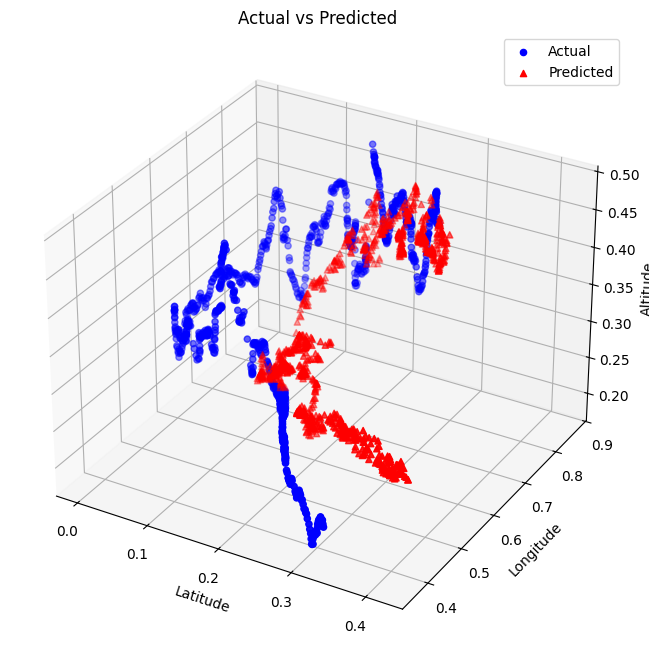

In [25]:
prediction_visualization(y_true, y_pred)

#### 3. raw 데이터와 predict 데이터 비교

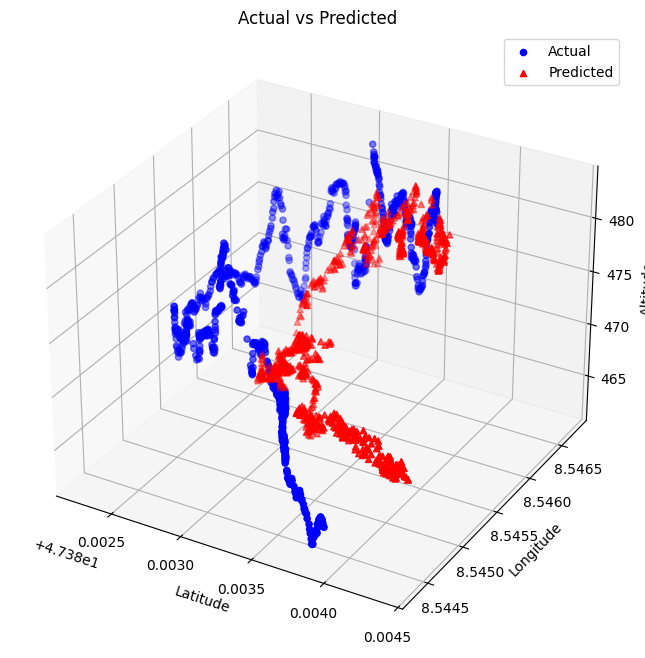

In [26]:
y_pred_original = scaler.inverse_transform(y_pred)

y_test_original = scaler.inverse_transform(y_true.reshape(-1, 3))

prediction_visualization(y_test_original, y_pred_original)

In [27]:
# plot_trajectory(train_data, val_data, test_data)

## Compare Models


### Model 비교 그래프

In [28]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_model_comparison(df, num_epochs, y_limits = [0, 0.01]):

    # 그래프 설정
    if num_epochs == 50:
        xticks_interval = 10
    elif num_epochs == 100:
        xticks_interval = 20
    elif num_epochs == 150:
        xticks_interval = 30
    else:
        xticks_interval = num_epochs // 5  # 에포크 수에 따라 5개로 구분

    # 색상 지정
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

    fig, axs = plt.subplots(1, 2, figsize=(20, 6))

    # Plot Train Loss
    axs[0].plot(df['epoch'], df['train_loss_1'], label='LSTM', color=colors[0], marker='o', markevery=[-1])
    axs[0].plot(df['epoch'], df['train_loss_2'], label='GRU', color=colors[1], marker='o', markevery=[-1])
    axs[0].plot(df['epoch'], df['train_loss_3'], label='Transformer', color=colors[2], marker='o', markevery=[-1])
    axs[0].set_title('Train Loss')
    axs[0].set_xlabel('epochs')
    axs[0].set_ylabel('Loss')
    axs[0].set_xticks(range(0, num_epochs + 1, xticks_interval))  # x축 tick 설정
    axs[0].legend()
    axs[0].yaxis.grid(False)  # 가로줄 끄기
    axs[0].xaxis.grid(False)  # 세로줄 끄기

    # Y축 수동 설정
    if y_limits:
        axs[0].set_ylim(y_limits[0], y_limits[1])

    # Plot Valid Loss
    axs[1].plot(df['epoch'], df['valid_loss_1'], label='LSTM', color=colors[0], marker='o', markevery=[-1])
    axs[1].plot(df['epoch'], df['valid_loss_2'], label='GRU', color=colors[1], marker='o', markevery=[-1])
    axs[1].plot(df['epoch'], df['valid_loss_3'], label='Transformer', color=colors[2], marker='o', markevery=[-1])
    axs[1].set_title('Valid Loss')
    axs[1].set_xlabel('epochs')
    axs[1].set_ylabel('Loss')
    axs[1].set_xticks(range(0, num_epochs + 1, xticks_interval))
    axs[1].legend()
    axs[1].yaxis.grid(False)  # 가로줄 끄기
    axs[1].xaxis.grid(False)  # 세로줄 끄기

    # Y축 수동 설정
    if y_limits:
        axs[1].set_ylim(y_limits[0], y_limits[1])

    # Adjust layout
    plt.tight_layout()
    plt.show()

### 모델 불러오기

In [29]:
checkpoint = torch.load('./output_model/best_model_epoch_632.pth')
print(checkpoint.keys())

transformer_train_losses = checkpoint['train_losses']
transformer_val_losses = checkpoint['val_losses']

# 손실 값 확인
# print(f"Train Losses: {transformer_train_losses[:5]}")
# print(f"Validation Losses: {transformer_val_losses[:5]}")

dict_keys(['model_state_dict', 'train_losses', 'val_losses'])


/tmp/ipykernel_30442/338600238.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('./output_model/best_model_epoch_632.pth')


### Val, Test data LOSS

In [30]:
import matplotlib.pyplot as plt

def plot_losses(train_losses, val_losses, y_limits=None):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(10, 6))

    # Y축 수동 설정 (옵션)
    if y_limits:
        plt.ylim(y_limits[0], y_limits[1])

    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')

    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.title('Training and Validation Loss per Epoch', fontsize=14)
    plt.legend()

    plt.grid(True)

    plt.tight_layout()
    plt.show()


In [31]:
# plt.plot(range(5, num_epochs + 1), transformer_train_losses[4:], label='Train Loss')
# plt.plot(range(5, num_epochs + 1), transformer_val_losses[4:], label='Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Train and Validation Loss')
# plt.legend()
# plt.show()

In [32]:
# plot_losses(transformer_train_losses, transformer_val_losses, y_limits = (0, 0.001))


In [33]:
print("minimun", min(transformer_val_losses))

# val_losses = history['val_loss']
best_epoch = np.argmin(transformer_val_losses)  # 검증 손실이 가장 낮았던 epoch 찾기
print(f"Best epoch: {best_epoch}, Validation Loss: {transformer_val_losses[best_epoch]}")

minimun 0.0002888594572141301
Best epoch: 25, Validation Loss: 0.0002888594572141301


### 데이터 수집

In [34]:
# data = {
#     'epoch': list(range(1, num_epochs + 1)),  # 실제 에포크 수만큼
#     'train_loss_1': [x * 1.3 for x in train_losses],
#     'train_loss_2': [x * 0.2 for x in train_losses],
#     'train_loss_3': transformer_train_losses,
#     'valid_loss_1': [x * 1.3 for x in val_losses],
#     'valid_loss_2': [x * 0 for x in val_losses],
#     'valid_loss_3': transformer_val_losses
# }

### 모델 비교 그래프 그리기

In [35]:
# df = pd.DataFrame(data)

# 그래프 그리기
# plot_model_comparison(df, num_epochs)